<a href="https://colab.research.google.com/github/qassi2008/Benchmarking-Pre-trained-Transformers-for-Automated-Essay-Scoring-AES-/blob/main/eda_ellipse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Investigating NLP Benchmark Relevance for AES

# Data Description
The dataset presented here (the ELLIPSE corpus) comprises argumentative essays written by 8th-12th grade English Language Learners (ELLs). The essays have been scored according to six analytic measures: cohesion, syntax, vocabulary, phraseology, grammar, and conventions.

# Importing packages

In [ ]:
from IPython.display import clear_output, display_html
import os
import warnings
from pathlib import Path

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy import stats

# Train Test Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

warnings.filterwarnings('ignore')
print('All libraries are Successfully importerd')

All libraries are Successfully importerd


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Unzip the data**

In [1]:
!unzip feedback-prize-english-language-learning.zip -d /content/

unzip:  cannot find or open feedback-prize-english-language-learning.zip, feedback-prize-english-language-learning.zip.zip or feedback-prize-english-language-learning.zip.ZIP.


# **Exploratory Data Analysis**

Basic Information

In [ ]:
# Load each of the datasets we are given
def load_data():
    data_dir = Path("C:/Users/UCS/Desktop/Aziz Qessi")
    train = pd.read_csv(data_dir / "/content/train.csv")
    test = pd.read_csv(data_dir / "/content/test.csv")
    sample_submission = pd.read_csv(data_dir / '/content/sample_submission.csv')
    return train, test, sample_submission

# Prints basic information about the datasets we are given.
from termcolor import colored
def data_info(csv, name="Train"):
    print(colored('==== {} ===='.format(name), 'blue', attrs=['bold']))
    print(colored('Shape: ', 'blue', attrs=['bold']), csv.shape)
    print(colored('NaN Values: ', 'blue', attrs=['bold']), csv.isnull().sum().sum(), '\n')
    #print(colored('Columns: ', 'blue', attrs=['bold']), list(csv.columns))

    display_html(csv.head())
    if name != 'Sample Submission': print("\n")

train, test, sample_submission = load_data()
clear_output()

names = ["Train", "Test", "Sample Submission"]
for i, df in enumerate([train, test, sample_submission]):
    data_info(df, names[i])

==== Train ====
Shape:  (3911, 8)
NaN Values:  0 



,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5




==== Test ====
Shape:  (3, 2)
NaN Values:  0 



,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."




==== Sample Submission ====
Shape:  (3, 7)
NaN Values:  0 



,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
train.select_dtypes(['int','float']).describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.000000,3.127077,0.662542,1.000000,2.500000,3.000000,3.500000,5.000000
syntax,3911.000000,3.028254,0.644399,1.000000,2.500000,3.000000,3.500000,5.000000
vocabulary,3911.000000,3.235745,0.583148,1.000000,3.000000,3.000000,3.500000,5.000000
phraseology,3911.000000,3.116850,0.655997,1.000000,2.500000,3.000000,3.500000,5.000000
grammar,3911.000000,3.032856,0.699841,1.000000,2.500000,3.000000,3.500000,5.000000
conventions,3911.000000,3.081053,0.671450,1.000000,2.500000,3.000000,3.500000,5.000000


* Essay example:

In [ ]:
train['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

**Cleaning full_text with Regular Expressions**

In [ ]:
import re

train['full_text'] = train["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
test['full_text'] = test["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

In [ ]:
from nltk.tokenize import word_tokenize
from collections import Counter

corpus = ''.join(train.full_text)
d = Counter(corpus.split())
words_counting = pd.DataFrame({'words':list(d.keys()), 'count':list(d.values())})
words_counting['word_len'] = words_counting['words'].apply(lambda x: len(x))
words_counting = words_counting.sort_values(by = 'word_len', ascending = False)

In [ ]:
words_counting['words'].head(1)

,words
10471,"ride,rock-climb,roller-skating,surfing,camping..."


In [ ]:
print('Amount of Generic Sequences: ',words_counting[words_counting.words.str.contains('Generic')]['count'].sum())

Amount of Generic Sequences:  1769


In [ ]:
for text in train.full_text:
    for w in text.split():
        if w == 'Generic_Name,Generic_Name,':
            print(text)
            break

"Where is one place in the world you would like to visit?"  "We should to go to  Generic_City over the summer, and talk to new people!" I excitedly told my friends 3 weeks before the school was gonna end. My friends, Generic_Name,Generic_Name, Generic_Name, and I think that Generic_City is the best place that we can go visit, because it can be a very exiting experience, and we can go out to see the Eiffel Tower, and experience the life of other people.  First I would visit the Eiffel tower with my friends.  The amazing height of the Eiffel tower. When we were walking to go see the Eiffel tower, it didn't seem big, but when we got closer, it seemed huge, I was shocked because I never knew that it was very huge. Then on the top of the Eiffel Tower, the city can be seen. As we were on the top of the Eiffel tower I could not believe that I could see the beautiful view of the lights of the city. Finally we took pictures of the the beautiful surroundings of the Tower. My friends were very ha

# Scoring Measurements Analysis

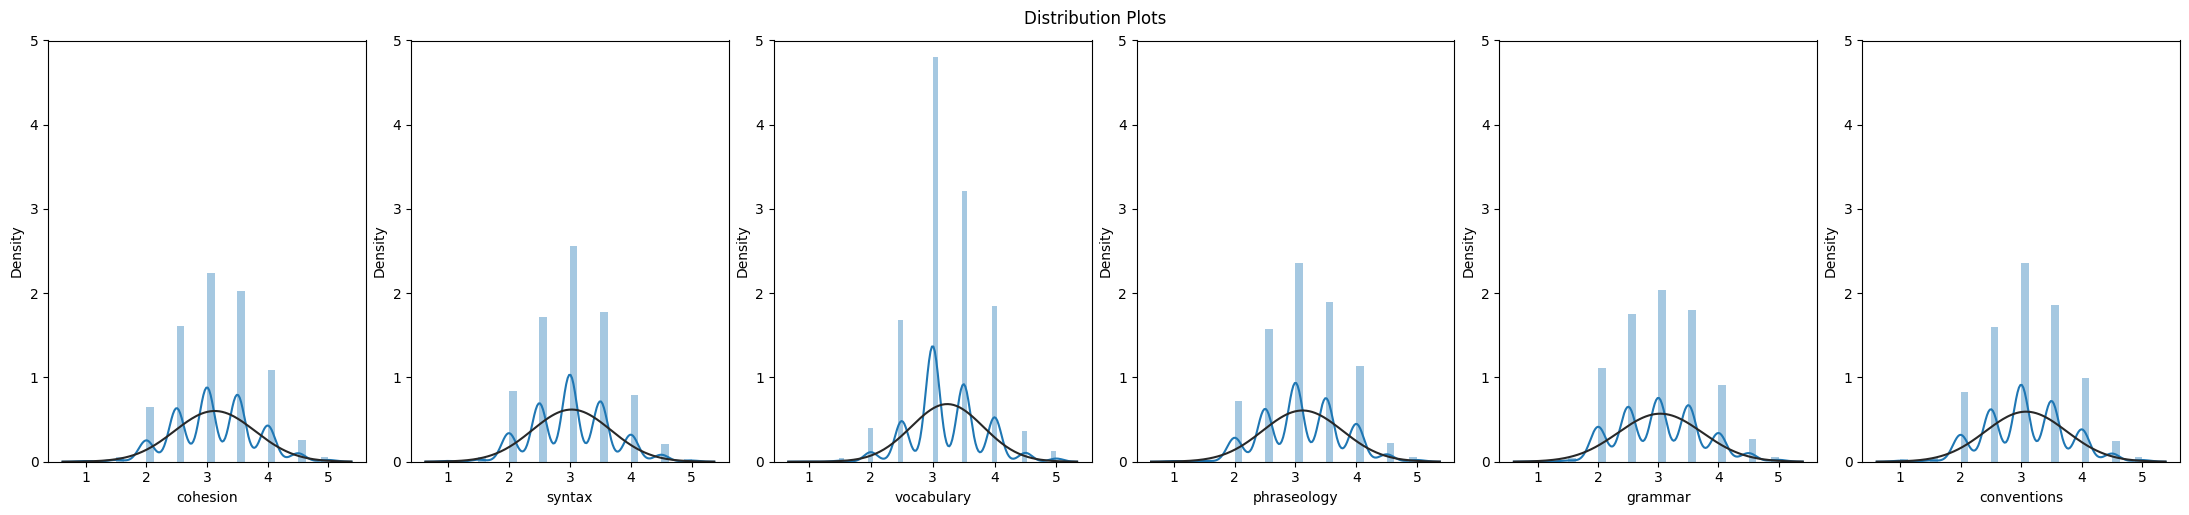

In [ ]:
# display distribution plots for the numerical columns in the train DataFrame
from scipy import stats

figure = plt.figure(figsize = (22,5))
for i, col in enumerate(train.select_dtypes(['int','float']).columns):
    ax = plt.subplot(1, 6, i+1)
    if train[col].dtype == 'int':
        sns.distplot(train[col], fit=stats.norm, color = 'red')
    else:
        sns.distplot(train[col], fit=stats.norm)
    ax.set_ylim((0.0, 5.0))
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Distribution Plots', y=1.02)
plt.show()

* Insight: there are much more passes than failures, in each of the scoring measurements.

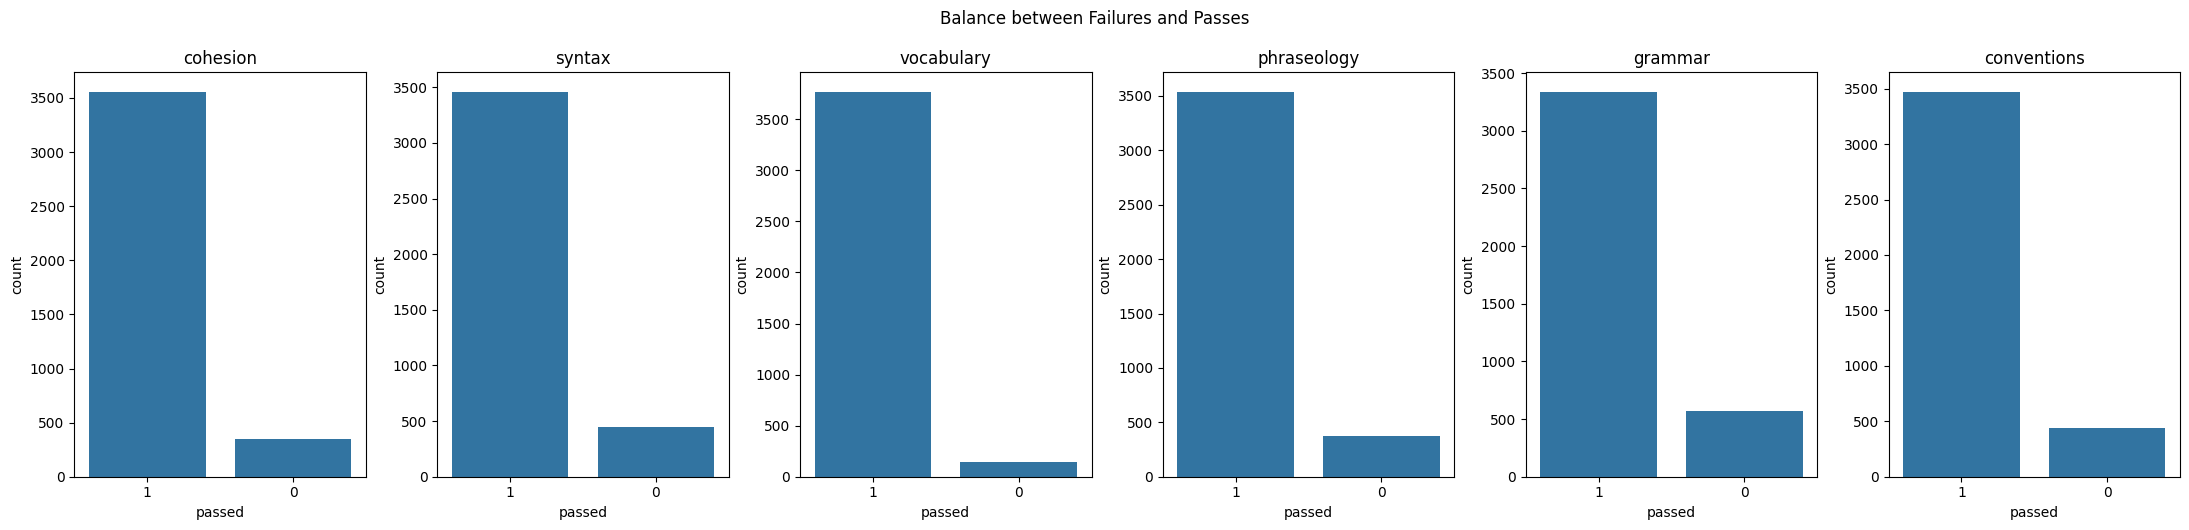

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
figure = plt.figure(figsize=(22, 5))

# Loop through the first 6 numeric columns in the train dataset
for i, col in enumerate(train.select_dtypes(['int', 'float']).columns[:6]):
    ax = plt.subplot(1, 6, i + 1)

    # Define the condition for passing or failing based on the column values
    conditionlist = [(train[col] >= 2.5), (train[col] < 2.5)]
    choicelist = [1, 0]

    # Create a new column 'passed' based on the conditions
    train['passed'] = np.select(conditionlist, choicelist, default='Not Specified')

    # Plot the count of passes and failures using sns.countplot
    sns.countplot(x='passed', data=train, ax=ax)

    # Remove the 'passed' column after plotting to avoid interference in subsequent iterations
    del train['passed']

    # Set the title of the subplot to the current column name
    ax.set_title(col)

# Adjust the layout to avoid overlap
figure.tight_layout(h_pad=1.0, w_pad=0.5)

# Add a title for the entire figure
plt.suptitle('Balance between Failures and Passes', y=1.05)

# Show the plot
plt.show()

Text(0.5, 1.0, 'Character Count')

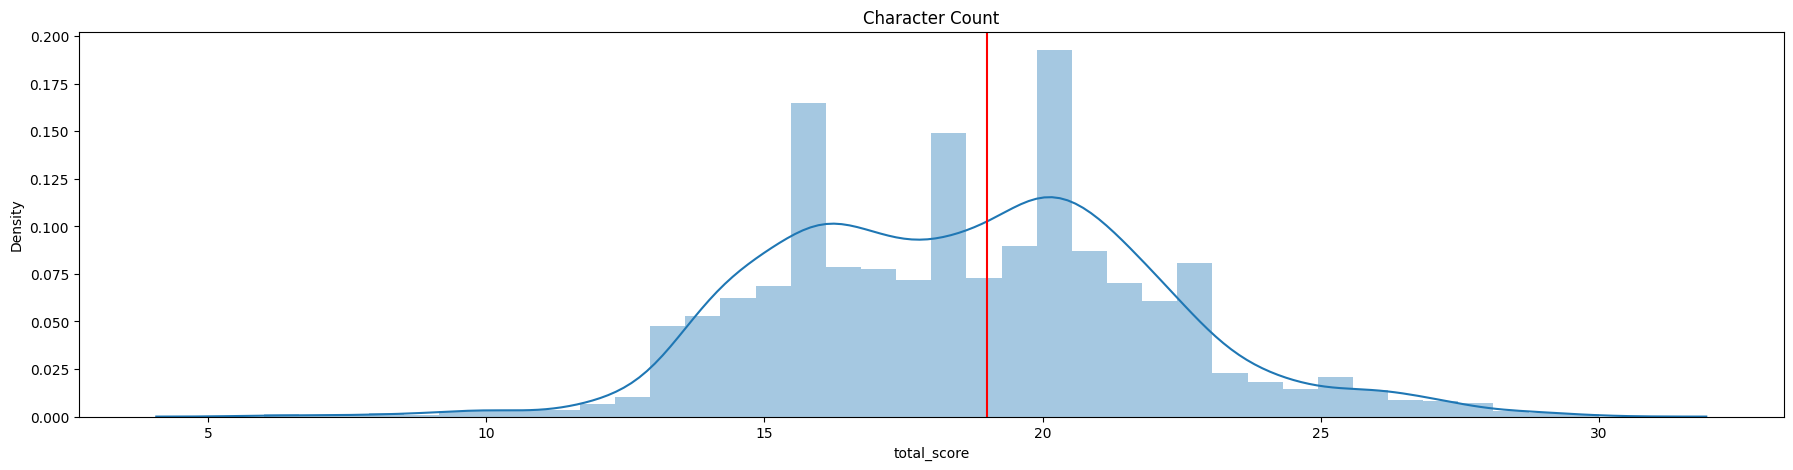

In [ ]:
# Creating a New Column total_score
train['total_score'] = train['cohesion'] + train['syntax'] + train['vocabulary'] + \
                       train['phraseology'] + train['grammar'] + train['conventions']

#  Calculating the Average total_score
avg_char = round(train['total_score'].mean())

plt.figure(figsize = (22,5))
sns.distplot(train['total_score'])

plt.axvline(x = avg_char, color = 'red')
plt.title('Character Count')

# example of a perfect essay (score = 30.0):

In [ ]:
train['full_text'][2389]

"I agree with Michelangelo's statement as I have found through experience that it benefits me more to set high expectations and not reach my goal, rather than settling on a low goal and achieving it. When setting high goals, I find that I learn more and progress my abilties further than I do with a lower goal. This is because setting high goals requires confidence, challenges, and pride.  Firstly, hard work is required to achieve high goals, and requires confidence. Confidence involves having trust and believing that you are capable of accomplishing something. I have found that when I set high goals, I feel more confident in my abilities. With lower goals however, my confidence is lower as I settle for the easier path and do not trust myself to do better. With a higher aim, my confidence motivates me to not give up. I tend to try harder, and always believe in myself. For example, at school, I had to choose whether I wanted to try out for the varsity tennis team or remain in the club te

Character Count
> This analysis is helpful in tasks where text length might influence model performance, such as text classification or sentiment analysis, and it gives a quick insight into the dataset’s content length.

In [ ]:
# Creating a New Column ncharacters
train['ncharacters'] = train['full_text'].str.len()

# Calculating the Average Number of Characters
avg_char = round(train['ncharacters'].mean())

# Calculating the Maximum Number of Characters
max_char = round(train['ncharacters'].max())
print('Average length: {}'.format(avg_char))
print('Max length: {}'.format(max_char))

Average length: 2335
Max length: 6044


Text(0.5, 1.0, 'Character Count')

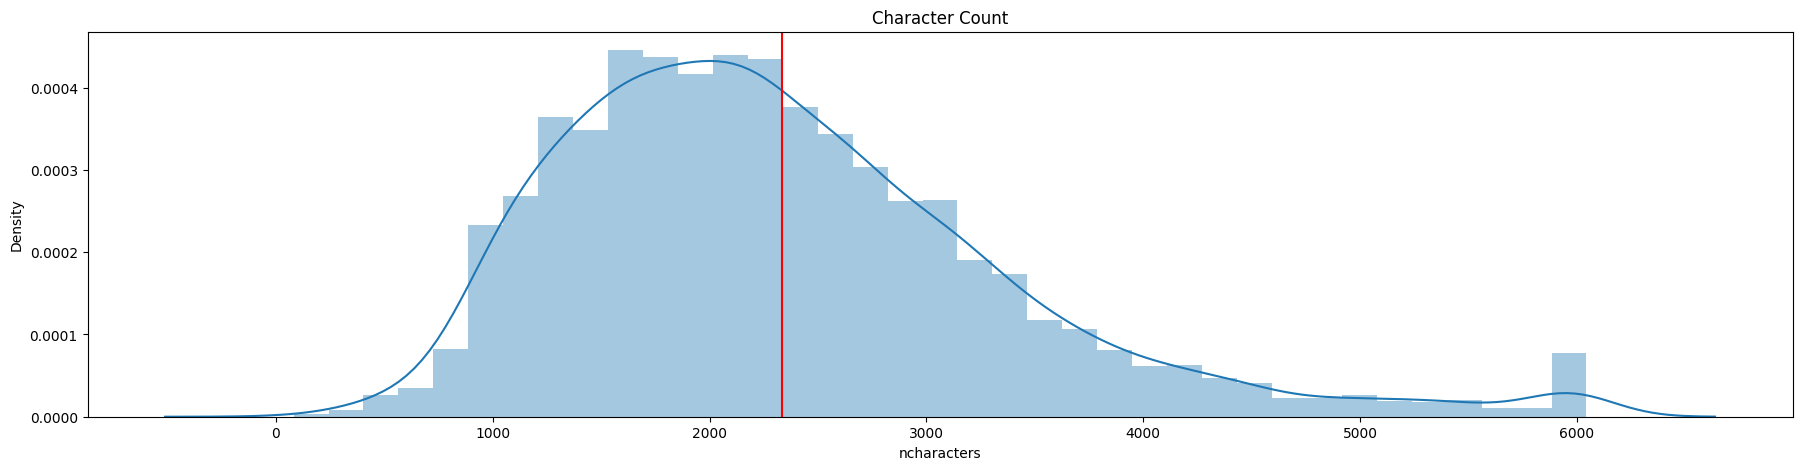

In [ ]:
plt.figure(figsize = (22,5))
sns.distplot(train['ncharacters'])
plt.axvline(x = avg_char, color = 'red')
plt.title('Character Count')

**Word Count**
* the word count distribution across the dataset. The token count will inform settings for our model, like max sequence length and the types of model architectures we can use. Only some are suitable for very long sequences.

In [ ]:
# Creating a New Column nwords
train['nwords'] = train['full_text'].apply(lambda x: len(x.split()))

avg_words = round(train['nwords'].mean())
max_words = round(train['nwords'].max())
print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

Average length: 430
Max length: 1260


Text(0.5, 1.0, 'Word count')

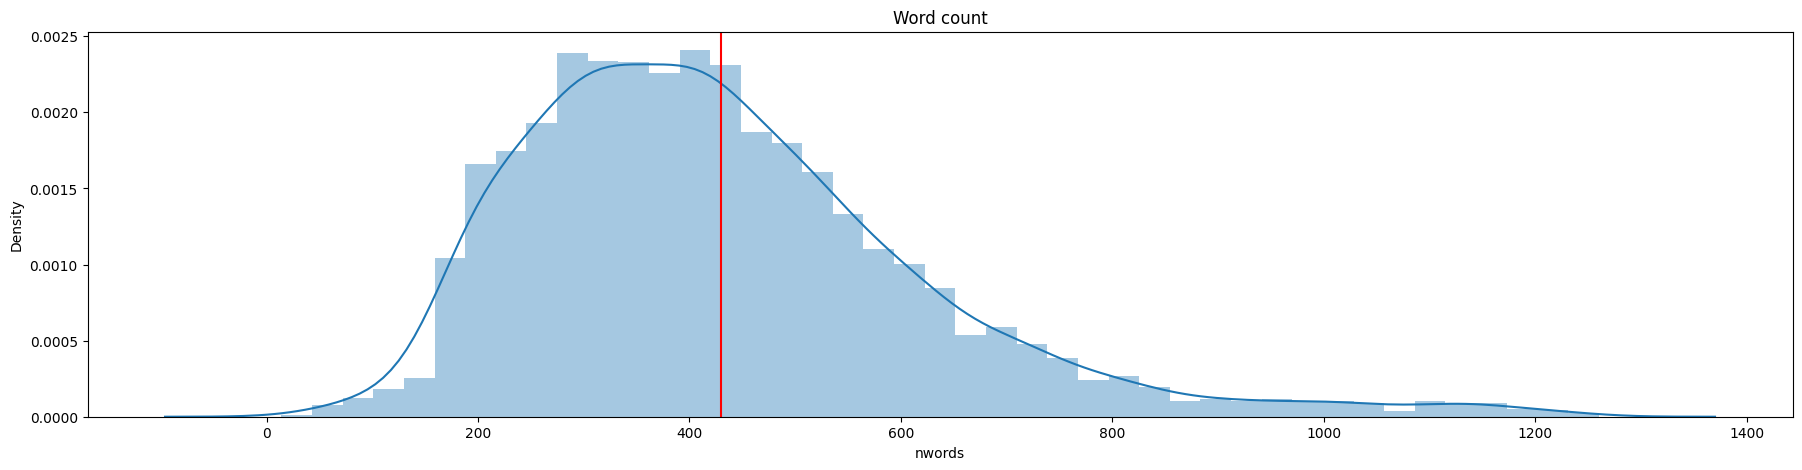

In [ ]:
# This visualization helps you understand the distribution of text lengths (in terms of word count) in the dataset.
plt.figure(figsize = (22,5))
sns.distplot(train['nwords'])
plt.axvline(x = avg_words, color = 'red')
plt.title('Word count')

* Word count tend to be greater for those essays having great scores. Except for grammar, where both means are almost equal.

In [ ]:
# visualize the relationship between performance groups (High, Mid, Low) in various scoring categories
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot distribution per score
def plot_distribution_per_score(c):
    scores = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    figure, axes = plt.subplots(nrows=1, ncols=6, figsize=(22, 5))

    for i, col in enumerate(scores):
        # Define conditions for performance categories
        conditionlist = [
            (train[col] >= 4.5),
            (train[col] >= 2) & (train[col] < 4.5),
            (train[col] < 2)
        ]
        choicelist = ['High', 'Mid', 'Low']
        train['performance'] = np.select(conditionlist, choicelist, default='Not Specified')

        # Create mask for each category
        mask_low = train.performance == 'Low'
        mask_mid = train.performance == 'Mid'
        mask_high = train.performance == 'High'

        # Plot separate Kernel Density Estimate KDE plots for Low and High performance groups
        sns.kdeplot(train[mask_low][c], ax=axes[i], color='green', label='Low', fill=True)
        sns.kdeplot(train[mask_high][c], ax=axes[i], color='orange', label='High', fill=True)

        # Add vertical lines for the means of Low and High performance groups
        avg_low = train[mask_low][c].mean()
        axes[i].axvline(x=avg_low, color='green', linestyle='--', label=f'Low Mean: {avg_low:.2f}')

        avg_high = train[mask_high][c].mean()
        axes[i].axvline(x=avg_high, color='orange', linestyle='--', label=f'High Mean: {avg_high:.2f}')

        # Set title and labels
        axes[i].set_title(col)
        axes[i].legend()

        # Clean up 'performance' column
        del train['performance']

    # Adjust layout to avoid overlapping
    figure.tight_layout()
    plt.show()

* Word count tend to be greater for those essays having great scores. Except for grammar, where both means are almost equal.

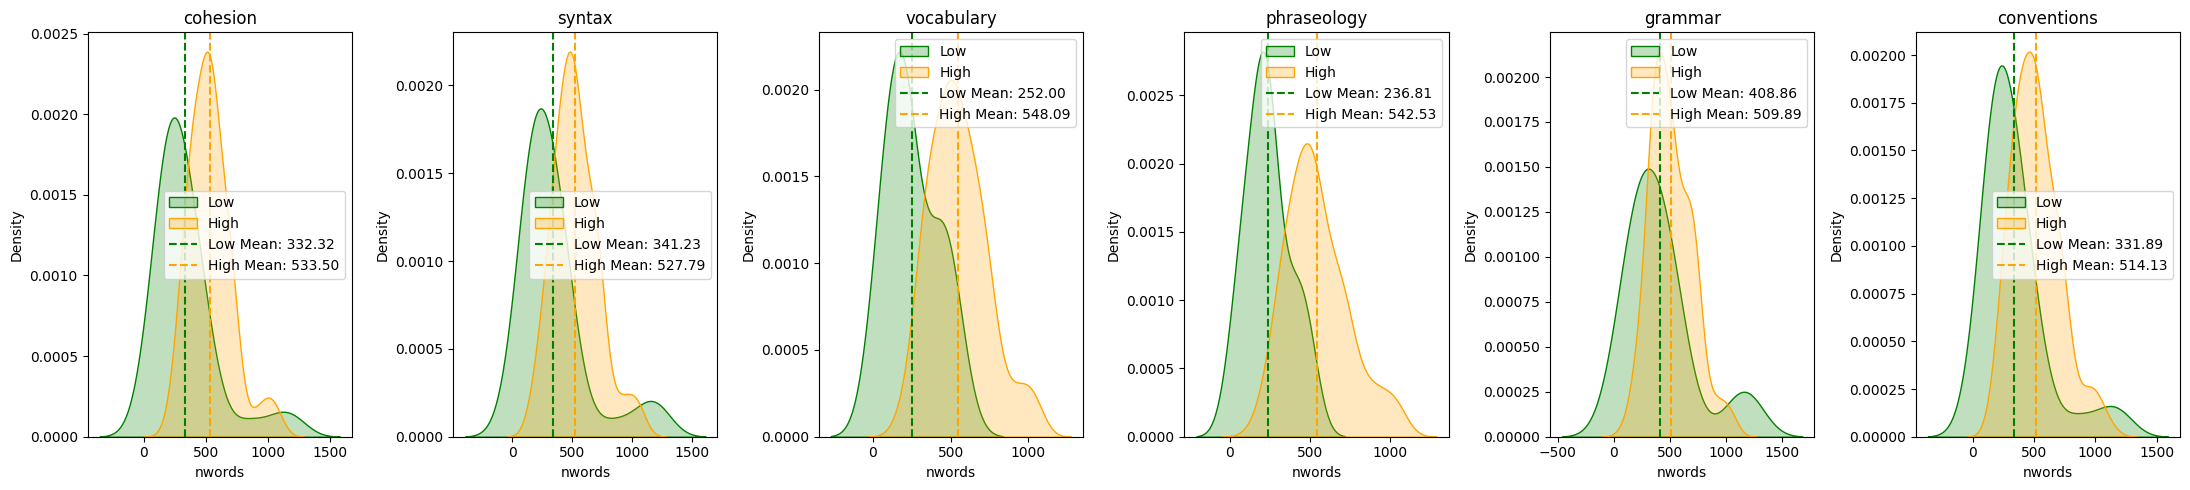

In [ ]:
# Call the function with 'nwords'
plot_distribution_per_score('nwords')

# Sentence Count and Average Length

calculates how many sentences each text contains and what the average number of sentences is across all texts.

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.tokenize import sent_tokenize

train['sent_count'] = train['full_text'].apply(lambda x: len(sent_tokenize(x)))
avg_sent = round(train['sent_count'].mean())
print('Average Count: {}'.format(avg_sent))

train['avg_sent_len'] = train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
avg_sent_len = round(np.mean(train['avg_sent_len']))
print('Average Sentence Length: {}'.format(avg_sent_len))


Average Count: 18
Average Sentence Length: 30


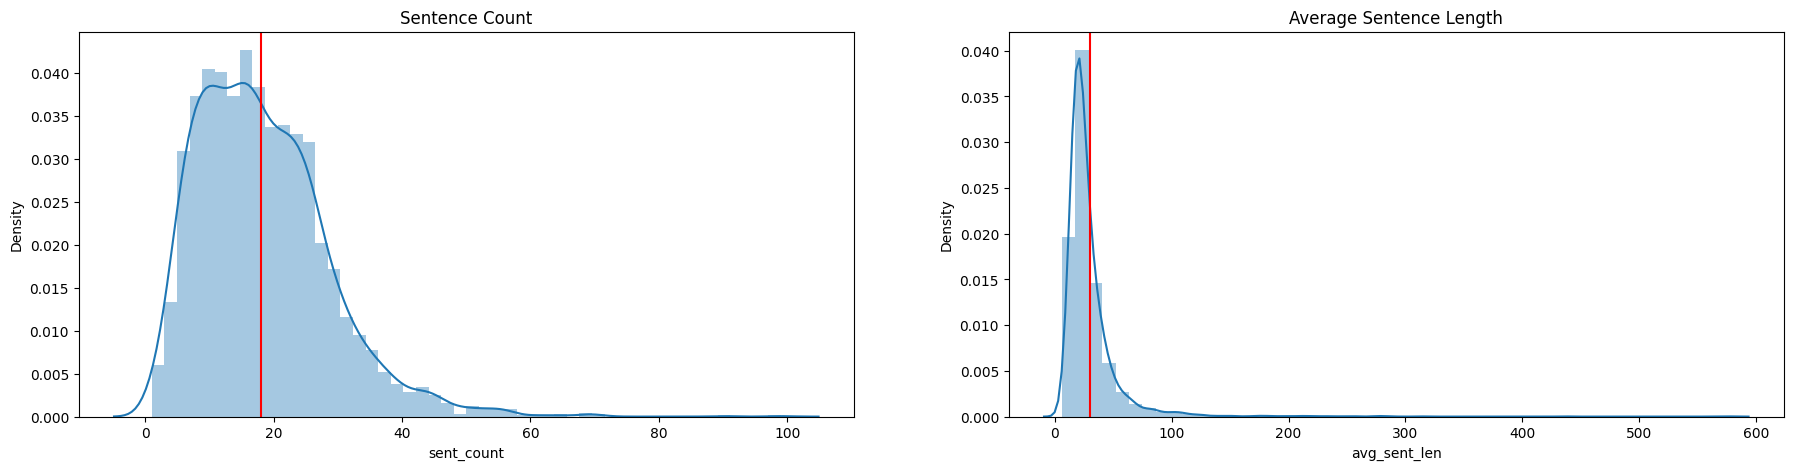

In [ ]:
plt.figure(figsize = (22,5))
for i, col in enumerate(['sent_count','avg_sent_len']):
        title = 'Sentence Count' if i == 0 else 'Average Sentence Length'
        mean = avg_sent if i == 0 else avg_sent_len
        ax = plt.subplot(1, 2, i+1)
        sns.distplot(train[col])
        ax.axvline(x = mean, color = 'red')
        ax.set_title(title)

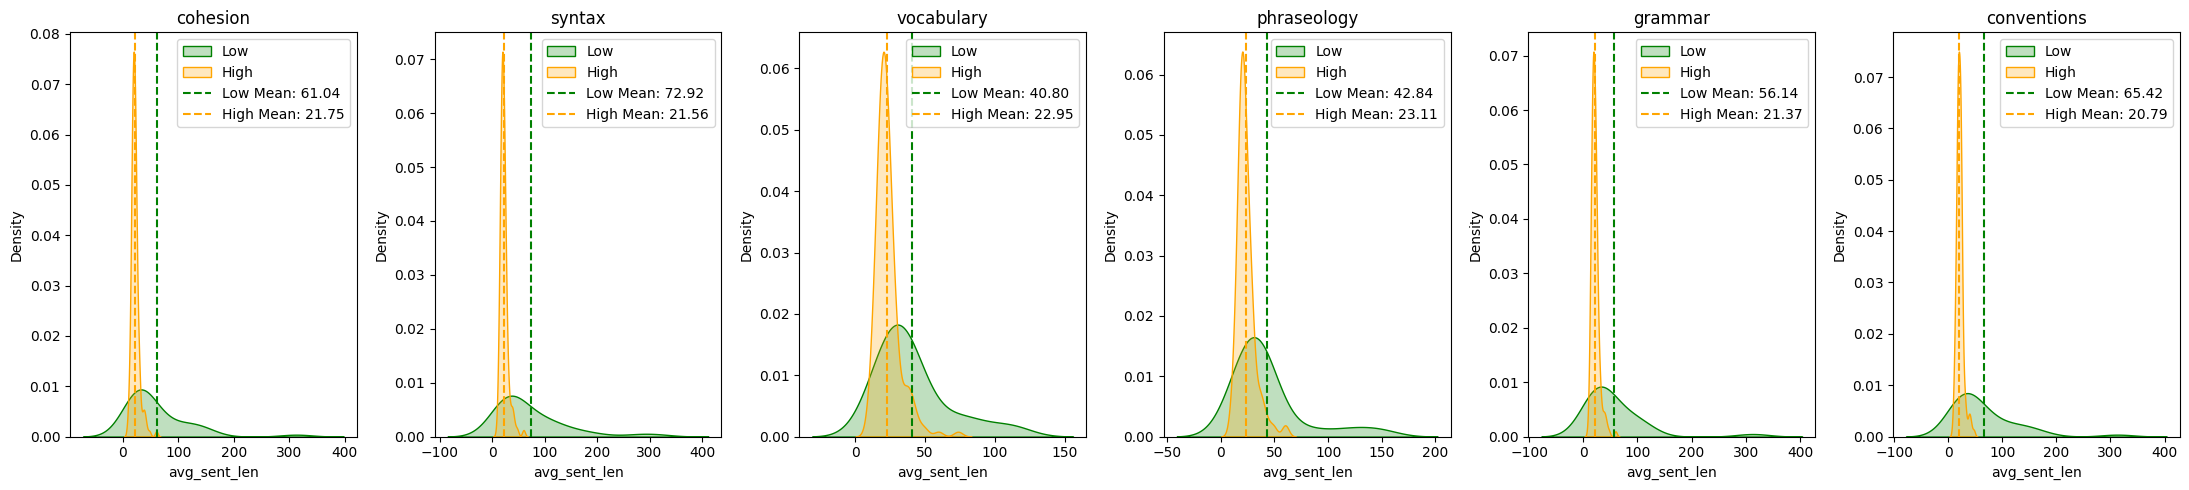

In [ ]:
plot_distribution_per_score('avg_sent_len')

# Stop Words
* By stop words we are referring to a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words.

In [ ]:
from nltk.corpus import stopwords

# Download the 'stopwords' dataset
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words('english'))
print("List of english stopwords -")
print(eng_stopwords)

List of english stopwords -
{"weren't", 'is', 'these', 'm', 'themselves', 'should', 'couldn', 'having', 'no', 'before', "mustn't", "should've", 'being', 's', "couldn't", 'down', "hadn't", 'in', "mightn't", 'to', "you've", 'by', 'those', 'it', "needn't", 'during', 'above', 'whom', 'at', 'on', 'be', 'had', 'its', 'are', 'for', 'few', 'shouldn', 'will', 'as', 'just', 'then', 'what', 'am', 'while', "didn't", 'more', 'wasn', 'does', 'doesn', 'you', 'if', 'herself', 'o', 'each', 'ourselves', 'other', 'same', 'but', 'the', 'my', 'why', 'here', 'myself', 'hasn', 'such', "shan't", 'which', 'mustn', 'so', 'an', 'after', "you're", 'weren', 'up', 'again', 'off', 'once', 'yourself', 'yourselves', 'further', 'hers', 'some', "you'll", 'their', "it's", 'both', "won't", 'this', 'she', 'that', 'been', 'against', 'out', "you'd", 'his', 'or', 'they', 'himself', 'didn', 'any', 'shan', 're', "haven't", 'ain', 'him', 'theirs', 'me', 'wouldn', 'until', 'below', "doesn't", 'haven', 'them', 'needn', 'don', "isn

This visualizes the 10 most frequent stopwords in the dataset.

<BarContainer object of 10 artists>

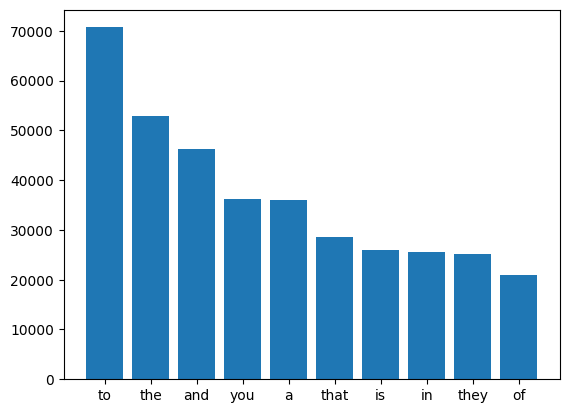

In [ ]:
import operator
from collections import defaultdict

corpus = ''.join(train.full_text).split()
dic = defaultdict(int)

for w in corpus:
    if w in eng_stopwords:
        dic[w] += 1

dic_sorted = sorted(dic.items(), key = operator.itemgetter(1), reverse = True)
x, y = zip(*dic_sorted[:10])
plt.bar(x,y)

# Most Frequent N-Grams
* What’s an n-gram? It’s a sequence of n words in a text. For example, the bi-grams (n = 2) for the sentence “How are you today?” would be: “How are”, “are you”, and “you today”. The tri-grams (n =3) would be “How are you” and “are you today”

In [ ]:
# This function takes a text string as input and applies several cleaning steps
import string

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters (not in the standard ASCII range)
    text = re.sub("([^\x00-\x7F])+", " ", text)
    return text

train_copy = train.copy()
train_copy['full_text'] = train_copy['full_text'].map(lambda x: clean_text(x))

The cleaned review texts

In [ ]:
train_copy['full_text'][0]

'i think that students would benefit from learning at homebecause they wont have to change and get up early in the morning to shower and do there hair taking only classes helps them because at there house theyll be pay more attention they will be comfortable at home  the hardest part of school is getting ready you wake up go brush your teeth and go to your closet and look at your cloths after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain then youll have to change with the online classes you can wear anything and stay home and you wont need to stress about what to wear  most students usually take showers before school they either take it before they sleep or when they wake up some students do both to smell good that causes them do miss the bus and effects on there lesson time cause they come late to school when u have online classes u wont need to miss lessons cause you can get everything set up and go take a shower and wh

 extracts n-grams (word sequences) from the text, ignoring stopwords, and calculates their frequency across the dataset.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert eng_stopwords to a list if it is not already
eng_stopwords = list(eng_stopwords)

def most_freq_ngrams(s1=2, s2=2):
    '''Return most frequent N-Grams for a size given.'''

    # Initialize CountVectorizer with stopwords as a list
    vec = CountVectorizer(stop_words=eng_stopwords, ngram_range=(s1, s2))

    # Matrix of ngrams
    bow = vec.fit_transform(train_copy["full_text"])

    # Count frequency of ngrams
    count_values = bow.toarray().sum(axis=0)

    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse=True))
    ngram_freq.columns = ["frequency", "ngram"]

    return ngram_freq

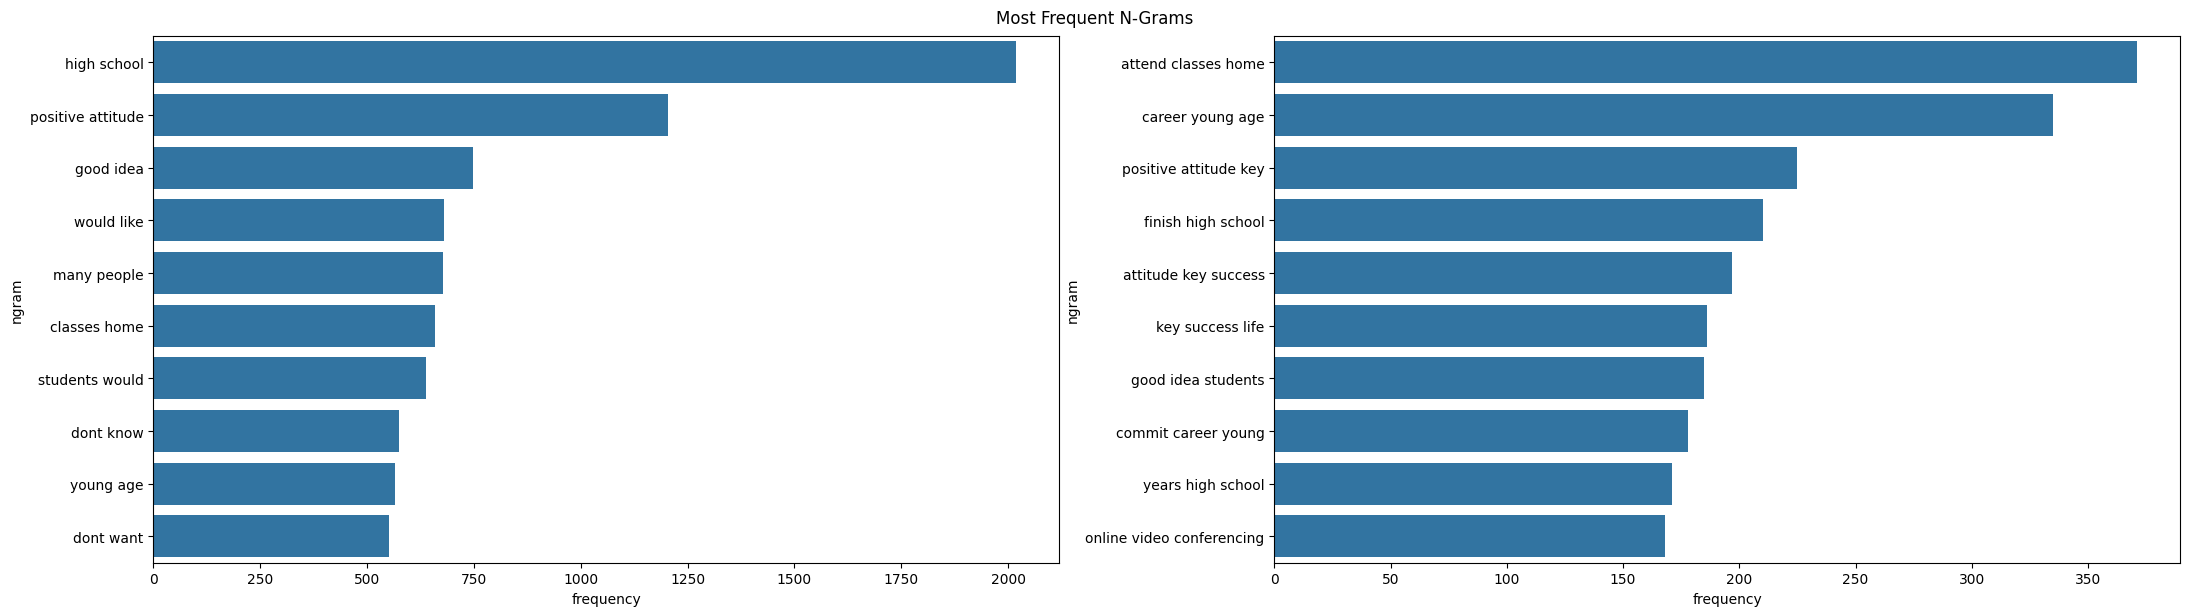

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))
for i in range(2, 4):
    ngram_freq = most_freq_ngrams(i, i)
    sns.barplot(data=ngram_freq[:10], x='frequency', y='ngram', ax=axes[i-2])
    del ngram_freq

figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Most Frequent N-Grams', y=1.02)
plt.show()

# Part of Speech Tagging (POS)

*  how to use it to get the most frequent adjectives, nouns, verbs, etc. In other words, with POS tagging, we are able to refine the EDA on the most frequent terms. E.g., you could explore, which adjectives or verbs are most common. POS tagging takes every token in a text and categorizes it as nouns, verbs, adjectives, and so on,

In [ ]:
from collections import Counter

# Returns all the tokens that are tagged as "tag" in tags.
def get_tokens(tags, tag_type = 'ADJ'):

    t = [word for word, pos in tags if ((pos == tag_type) & ( word not in eng_stopwords))]
    return t

# Calculate the most commont tokens tagged as "tag_type" in tags. Shows a Bar Plot with the results.
def show_most_common_tokens(tags, tag_type = 'ADJ', row = -1, col = -1):

    adj_tags = get_tokens(tags, tag_type)

    # Count most common adjectives
    most_common = Counter(adj_tags).most_common(10)

    # Visualize most common tags as bar plots
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)

    if col == -1: sns.barplot(x = frequency, y = words)
    else: sns.barplot(x = frequency, y = words, ax = axes[row][col])

In [ ]:
# Download the required data for the tagger
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

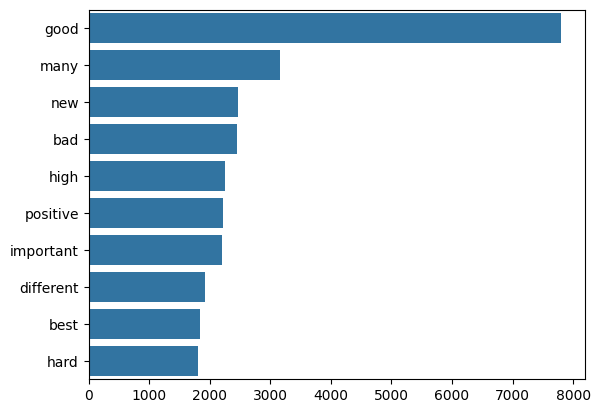

In [ ]:
corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")

show_most_common_tokens(tags, 'ADJ')

we are going to compare the most common tokens depending on each of the scores. The aim of this is to analyse which type of words appear more in low and high graded essays.

**verbs.**

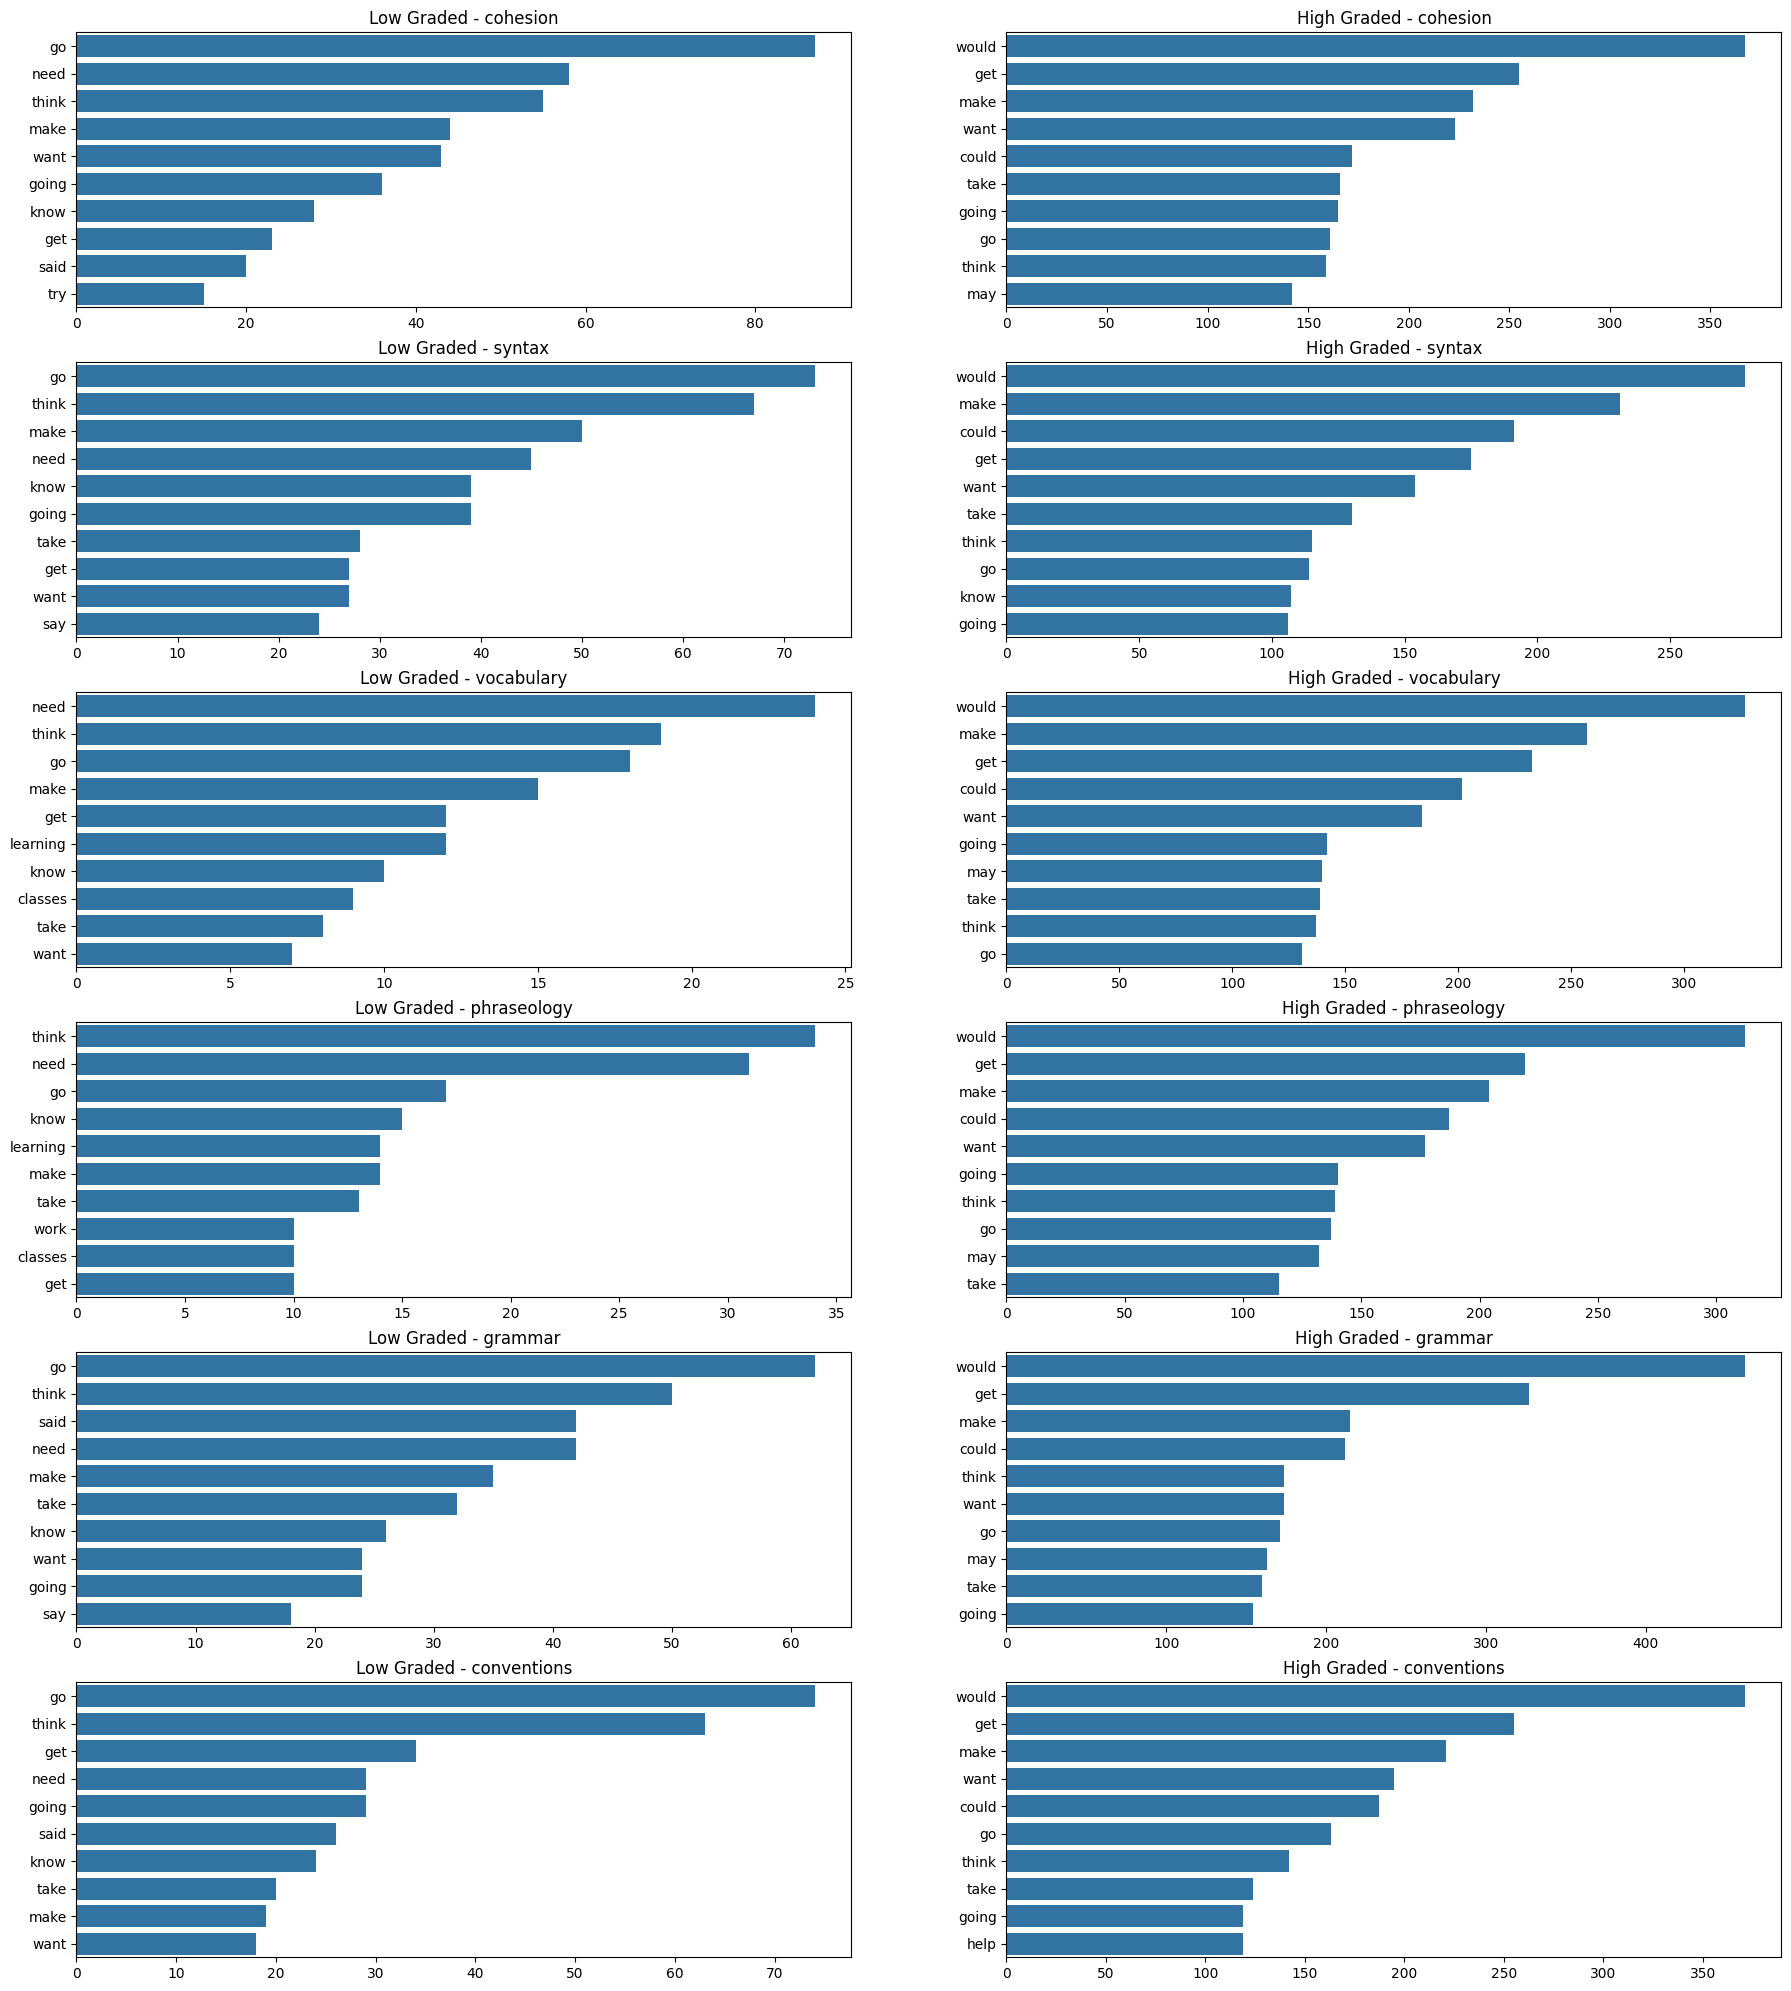

In [ ]:
scores = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
figure, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (22,25))

for i, col in enumerate(scores):
    for j in range(2):

        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train[col] < 2 if j == 0 else train[col] > 4

        corpus = ''.join(train[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")
        show_most_common_tokens(tags, 'VERB', i, j)
        axes[i,j].set_title(title)

**nouns**

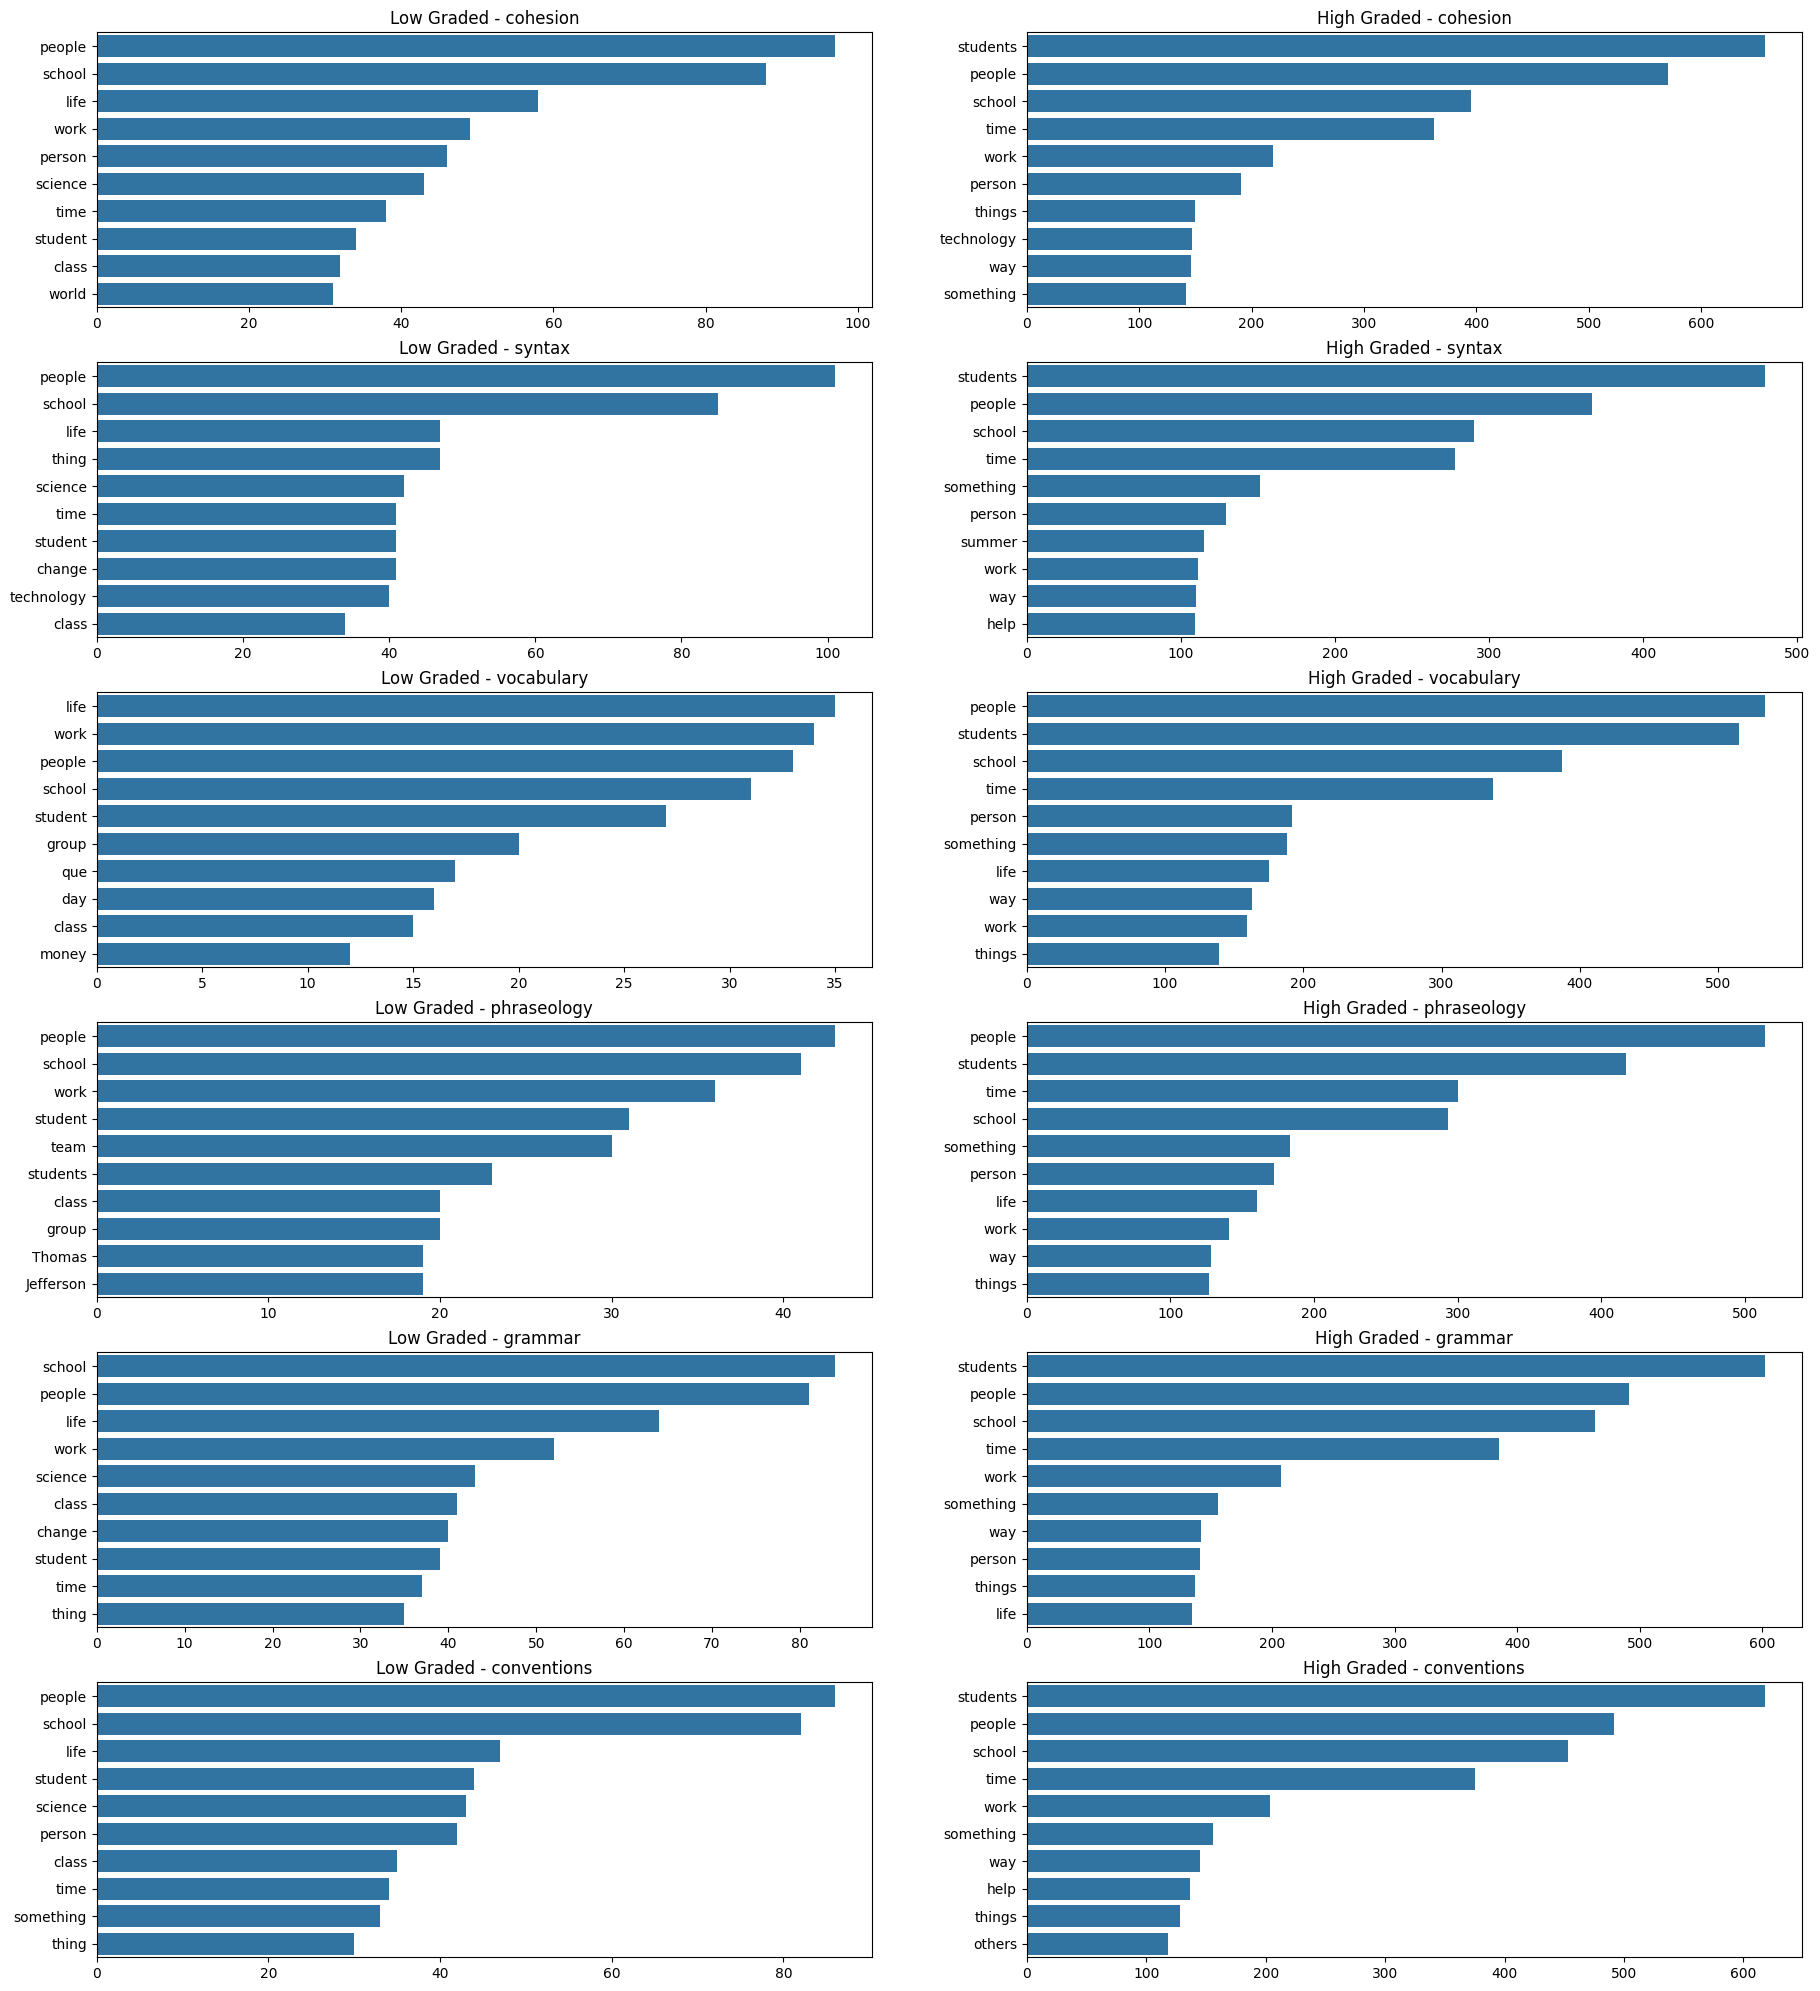

In [ ]:
figure, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (22,25))
for i, col in enumerate(scores):
    for j in range(2):

        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train[col] < 2 if j == 0 else train[col] > 4

        corpus = ''.join(train[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")
        show_most_common_tokens(tags, 'NOUN', i, j)
        axes[i,j].set_title(title)

# Correlations

By examining the following chart we can conclude the following:

* High correlation between scoring measurements suggests that essays tend to have similar grades in each of the measurements.

* Avg_sent_len is negatively correlated with every scoring measure. Thus, we can conclude that very long phrases could have a negative impact on how an essay is graded. This make sense when we observe sent_count as well. The shorter the phrases are, the more amount of phrases an essay has. That's the reason for its positive correlation with the scoring measurements.

> The first heatmap shows the correlation values without taking the absolute values, meaning it distinguishes between positive and negative correlations.
> The second heatmap shows the absolute values of the correlations, focusing purely on the strength of the relationships.

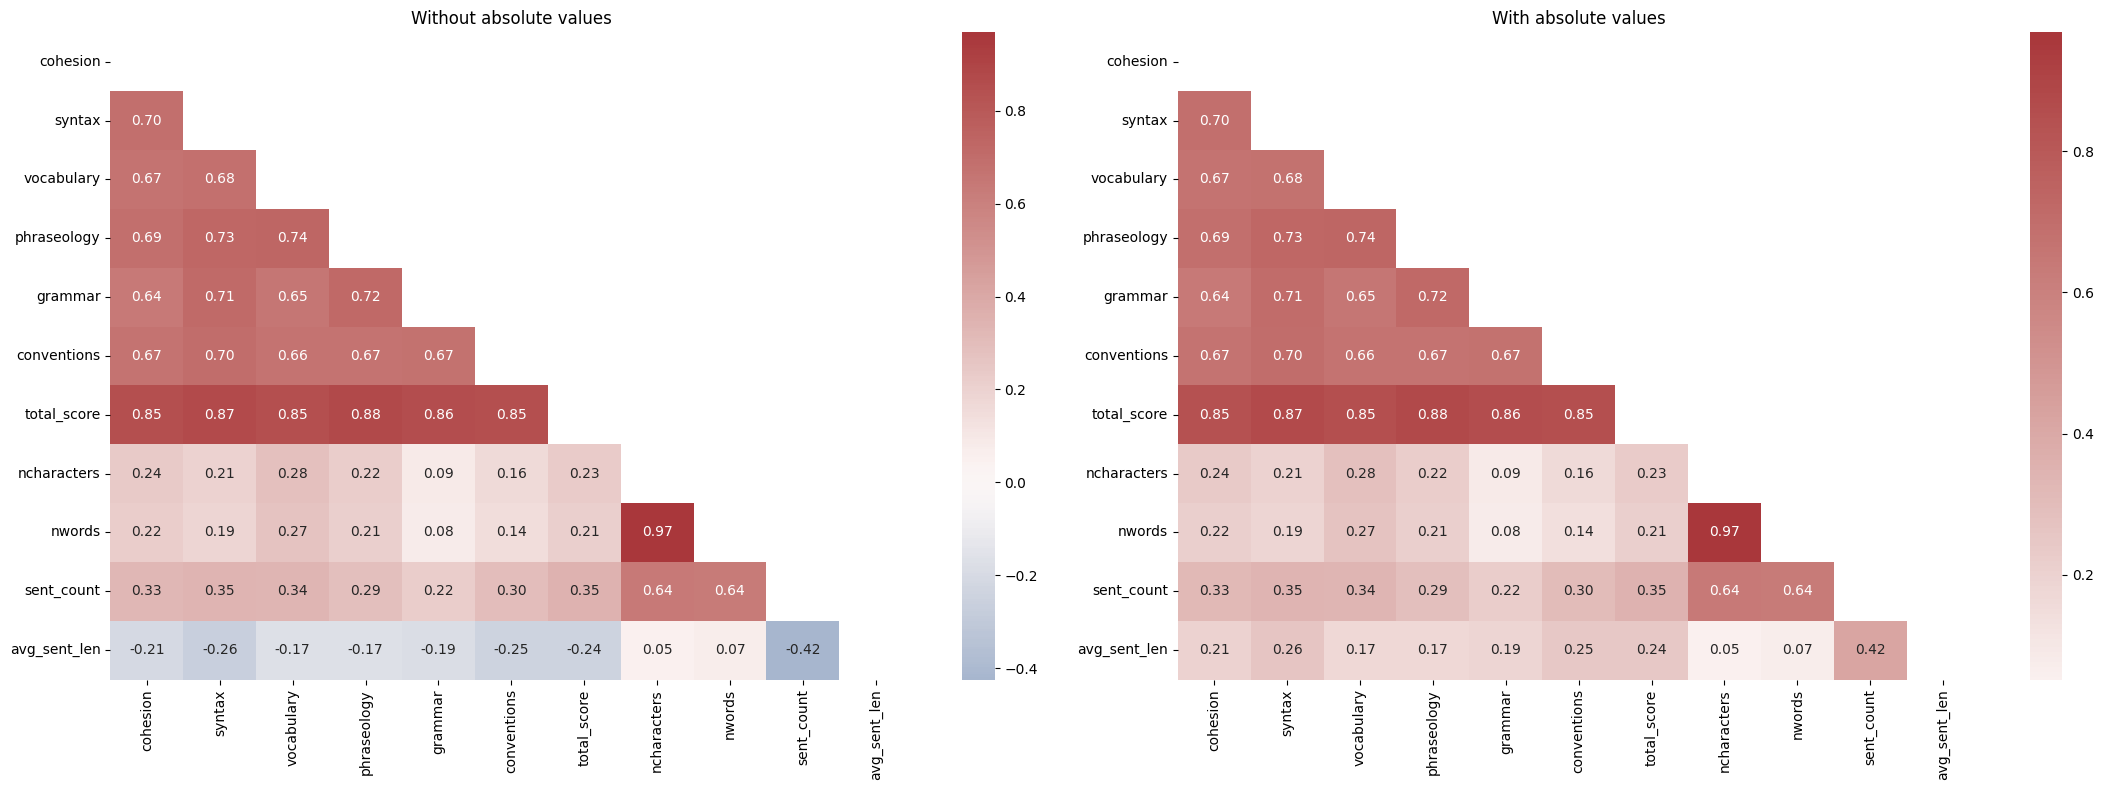

In [ ]:
corr= train.select_dtypes(['int','float']).corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22,8))
# Heatmap without absolute values
sns.heatmap(corr, mask=matrix, center = 0, cmap = 'vlag', ax = axes[0],
            annot=True, fmt='.2f').set_title('Without absolute values')
# Heatmap with absolute values
sns.heatmap(abs(corr), mask=matrix, center = 0, cmap = 'vlag', ax = axes[1],
           annot=True, fmt='.2f').set_title('With absolute values')

fig.tight_layout(h_pad=1.0, w_pad=0.5)

**Lemmatization**
> The process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors

In [ ]:
import nltk
print(nltk.data.path)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [ ]:
import nltk
nltk.download('wordnet', download_dir='/usr/share/nltk_data')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...


True

In [ ]:
import os

# List the contents of the directory to check if wordnet is present
print(os.listdir('/usr/share/nltk_data/corpora/'))

['wordnet.zip']


In [ ]:
import zipfile
import os

# Define the path to the wordnet.zip file
zip_path = '/usr/share/nltk_data/corpora/wordnet.zip'
extract_to = '/usr/share/nltk_data/corpora/'

# Check if the file exists and unzip it
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("wordnet.zip extracted successfully!")
else:
    print("wordnet.zip not found!")

wordnet.zip extracted successfully!


In [ ]:
import nltk
from nltk.corpus import wordnet

# Fetch synsets for a test word to check if wordnet is working
print(wordnet.synsets('word'))

[Synset('word.n.01'), Synset('word.n.02'), Synset('news.n.01'), Synset('word.n.04'), Synset('discussion.n.02'), Synset('parole.n.01'), Synset('word.n.07'), Synset('son.n.02'), Synset('password.n.01'), Synset('bible.n.01'), Synset('give_voice.v.01')]


In [ ]:
# Importing Lemmatizer library from nltk
nltk.download('omw-1.4')
clear_output()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))

rocks : rock
corpora : corpus


compare now which lemmas are the most common ones in essays with a perfect grade (5.0) in vocabulary and syntax, and the ones with a low grade (less or equal than 2.0).

In [ ]:
# Returns a dictionary with lemmas, sorted by frequency.
def most_common_lemmas(corpus):

    dic = defaultdict(int)
    for w in corpus:
        lemma = lemmatizer.lemmatize(w)
        dic[lemma] += 1

    dic_sorted = sorted(dic.items(), key = operator.itemgetter(1), reverse = True)
    return dic_sorted

* Most common lemmas are shared between both types of essays.
* However, from top 4/5 onwards the difference in technical lemmas start to be significant

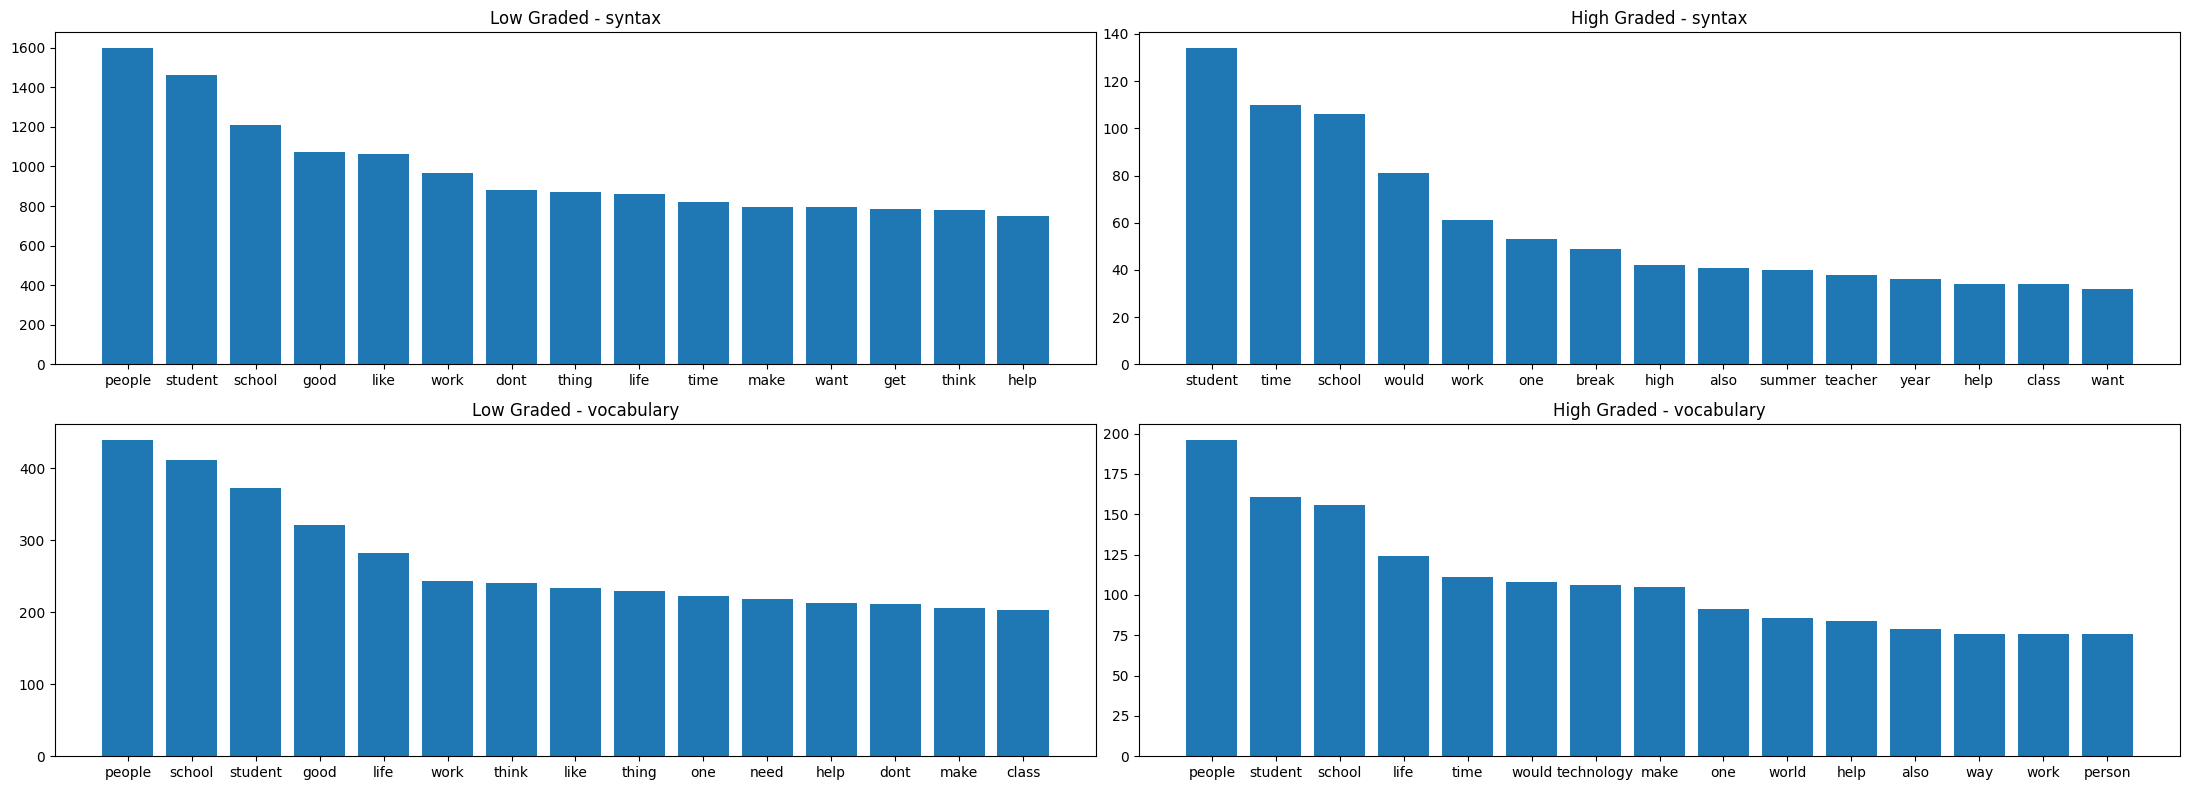

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (22,8))
for i, col in enumerate(['syntax','vocabulary']):
    for j in range(2):
        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train_copy[col] <= 2 if j == 0 else train_copy[col] == 5

        corpus = ''.join(train_copy[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        dic_sorted = most_common_lemmas(corpus_without_stop)
        x, y = zip(*dic_sorted[:15])
        axes[i, j].bar(x,y)
        axes[i, j].set_title(title)

figure.tight_layout(h_pad=1.0, w_pad=0.5)

# Word Cloud

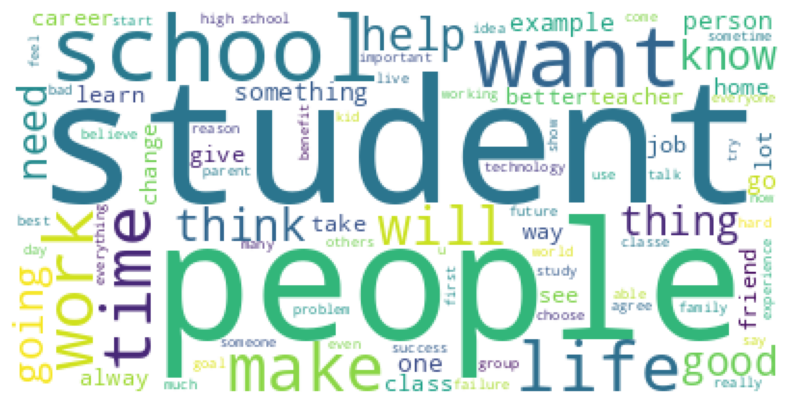

In [ ]:
from wordcloud import WordCloud

corpus = ''.join(train['full_text'])
wordcloud = WordCloud(background_color='white').generate(corpus)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Exploring through Text Complexity. Flesch Reading Ease (FRE)

Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages:

Text(0.5, 1.0, 'Text Complexity')

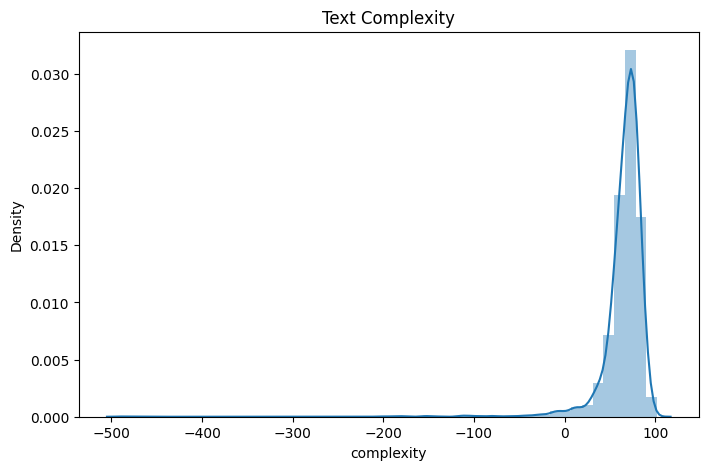

In [ ]:
!pip install textstat
clear_output()
from textstat import flesch_reading_ease

train['complexity'] = train['full_text'].apply(lambda x : flesch_reading_ease(x))
plt.figure(figsize = (8,5))
sns.distplot(train['complexity'])
plt.title('Text Complexity')

make a brief comparison depending on the complexity scores given to a text. We're gonna start by examining one with a relatively low score (between 10 - 20). That means, hard to read for a kid.

In [ ]:
train['full_text'][3039]

"I'm going to start explaining and giving my opinion, Technology is one of the main reasons, why the world is changing and accommodating with the necessities that the person have, for example: we live in a community that if everything is easier is better, few years ago people had to walk hours or days to go some where, on this days the transport is a lot easier because the technology had increased,  you can use or have your own car or you,  can take the public transport and go everywhere with out problems and if you want to go to another country you can! because the air lines exist now, and you can fly to go to the country you like.  So technology have a positive effect because is helping us to make our daily necessities at home or everywhere better, a reason why i think that is because the future of the students is going to be with more opportunities to learn what they like, with out saying excuses, the help of others is not going to be that necessary with technology in your hands; no

some essays that were given a pretty high score, in terms of complexity. To recap, those are the easiest essays to read.

In [ ]:
train['full_text'][2]

"Dear, Principal  If u change the school policy of having a grade b average that unfair. Because many students have a C average. So that means that they cant go out for sports or other activities they want to do bad. That's like taking everything they have. What if kids want to become good at something, but now they cant because of that school policy. If they have a C average they should still be able to go out for sports or activities. A C average isn't that bad, its higher then a D average. If the school police was if you have a D average of lower they shouldn't do sports or activities. If they have a D average in school for not working hard, that's means that they in ain't going to try hard. If they have a C average and there trying hard they should be able to out for sports or activities. What if all the good people in sports have a C average in school, that means that they cant play and were going to lose every game we have. That's a good policy to get grade's up but don't take aw

* The difference in complexity is clear between these two texts.
> However, while most essays have obtained a complexity score between 0 - 100, one incredible insight about the chart we showed before is the ridiculously low score that some texts are given.

In [ ]:
train['full_text'][39]

'my name is Generic_Name and my story is about cars  I bay a car and it new i live that car so mush so i stirt taking caer to it and befor I usto have a buskel and i usto love that baskel so mauh but i gat older so i stop riding a biskel and i stirt looking for a beges thengs whan i was a kid i usto so my dad driveng a car and i usto haveng fun in it  ;and my drimm was to bay a car win i gro up and i stil looking for that drimm seccer is the only sport i like i use to play seccer win i weas 11 years old and i stil play that geame and i love it so mush but my lieg get hert so i stop playing it any moer and then i stirt fling better so i want to go bake to play my favert game seccer so i try ot for school and i stirt making frinds and play with them my favert game evry day i even like a gril becoes that game so l like that gril and i stirt playing wiht her and taking wihe her and i wanted her number so i stirt beang cloes to her so it bean a year so i finly say it i told her that i love 

In [ ]:
train['full_text'][272]

"The year book is for to not forget anything and it helps you lot will somtimes people don't like it but for me it helps me lot but we don't the have it any of thoes no more it lets you to not to foget to do your homework and what do have torrmorw and the next week But we have those any more because we are now 8th grades but the kids what year book to show thier family what spots they did even to show kids went to school even to show how there friends looks like and one day there family can met them even I agree to do it like what to show there family what did and there school looks like even for they can rember but also if there friends moves away and we will still rember even to love them so much but still I agree for to do the years book and I'am ok with it and what the year books still and I still love them and miss them lot I want them back and it actlly look good But like we only get them an a year it takes for ever to get and I think to pay to get your own one but I like and the

* In the first one, lots of bad-written words.
* The second one uses some non-sense and incorrect grammatical structures.
* Both essays have something in common. There are no punctuation marks !

# Sentiment Analysis
Polarity measures the sentiment (positive/negative) of the text, while subjectivity measures how subjective or objective the text is.

Text(0.5, 1.0, 'Subjetivity Distribution')

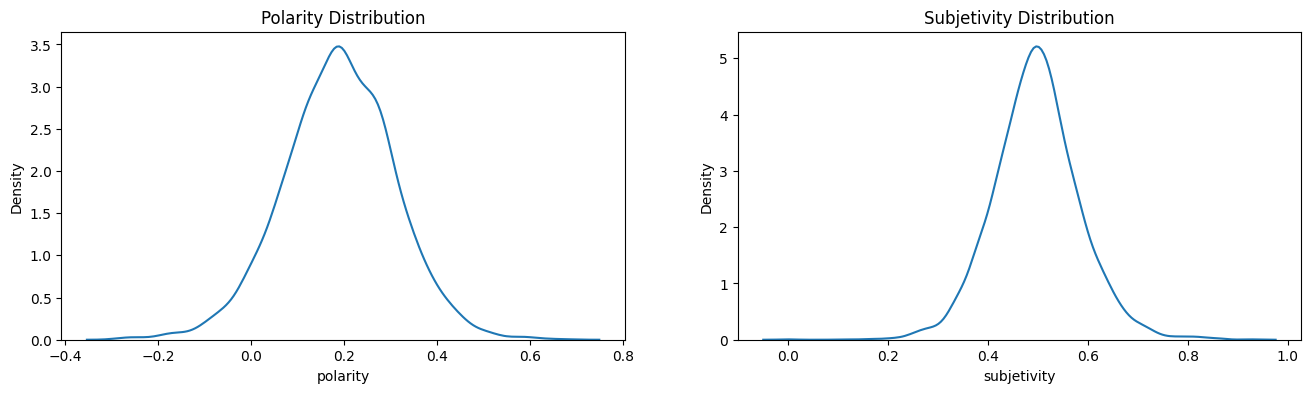

In [ ]:
from textblob import TextBlob

train['polarity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[0])
train['subjetivity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[1])
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
sns.kdeplot(train['polarity'], ax = axes[0])
axes[0].set_title('Polarity Distribution')
sns.kdeplot(train['subjetivity'], ax = axes[1])
axes[1].set_title('Subjetivity Distribution')

# Data Preprocessing

In [ ]:
def load_data():
    data_dir = Path("C:/Users/UCS/Desktop/Aziz Qessi")
    train = pd.read_csv(data_dir / "/content/train.csv")
    test = pd.read_csv(data_dir / "/content/train.csv")
    sample_submission = pd.read_csv(data_dir / '/content/sample_submission.csv')
    return train, test, sample_submission

train, test, sample_submission = load_data()

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)  # Remove punctuation
    text = re.sub("([^\x00-\x7F])+", " ", text)  # Remove non-Roman characters
    return text

train['full_text'] = train['full_text'].map(lambda x: clean_text(x))
test['full_text'] = test['full_text'].map(lambda x: clean_text(x))

# Feature Engineering

In [ ]:
# Extract Features from the Essays
train['ncharacters'] = train['full_text'].str.len()
train['nwords'] = train['full_text'].apply(lambda x: len(x.split()))
train['sent_count'] = train['full_text'].apply(lambda x: len(sent_tokenize(x)))
train['avg_sent_len'] = train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))

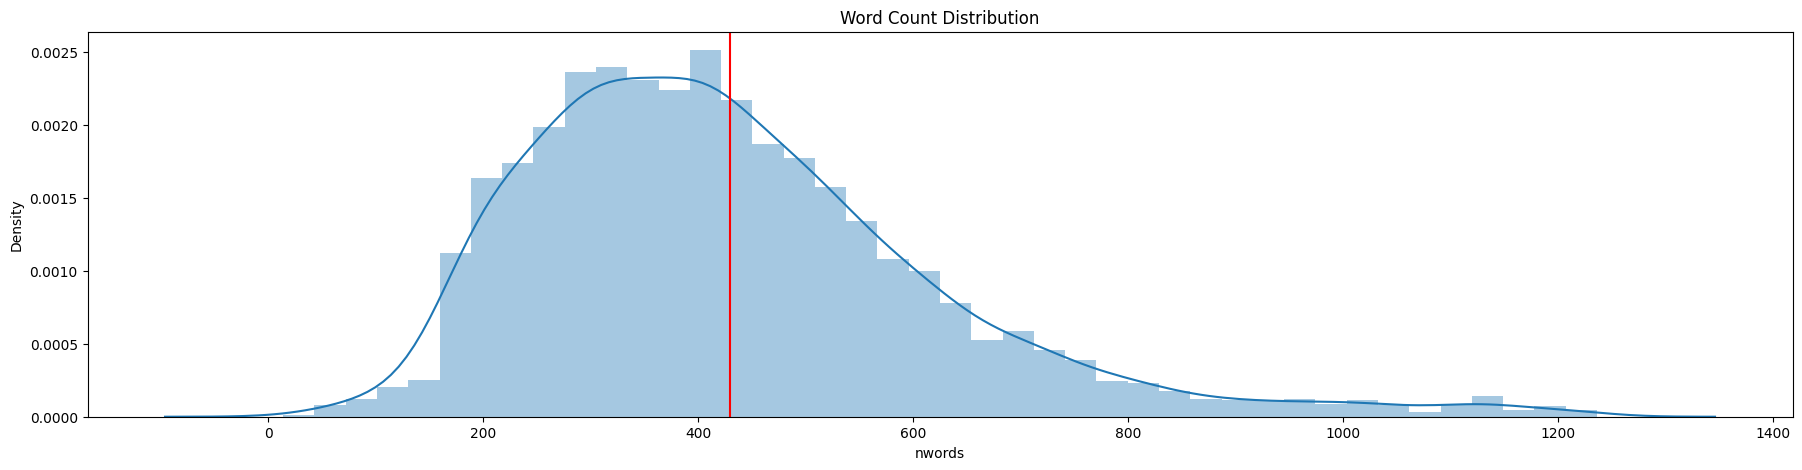

In [ ]:
plt.figure(figsize=(22, 5))
sns.distplot(train['nwords'])
plt.axvline(x=train['nwords'].mean(), color='red')
plt.title('Word Count Distribution')
plt.show()

# Modeling

# Deberta-v3-base

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = 'C:/Users/UCS/Desktop/Aziz Qessi'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='FB3'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=20
    num_workers=4

    # microsoft/deberta-v3-base
    model="microsoft/deberta-v3-base" # here we can change the name of model # like'xlnet/xlnet-base-cased', 'google/electra-base-discriminator',,xlnet/xlnet-base-cased

    gradient_checkpointing=True
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=30
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    seed=42
    n_fold=2
    trn_fold=[0, 1, 2, 3]
    train=True
    num_levels = 2

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [ ]:
if CFG.wandb:

    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='FB3-Public',
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

os.system('pip install iterative-stratification==0.1.7')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels tokenizers')
!pip install tokenizers
import tokenizers
!pip install transformers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 86.9 MB/s eta 0:00:00
tokenizers.__version__: 0.21.0
transformers.__version__: 4.48.1
env: TOKENIZERS_PARALLELISM=true


**Utils**

In [ ]:
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

**Data Loading**

In [ ]:
train = pd.concat([pd.read_csv('/content/train.csv')])
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

print(f"train.shape: {train.shape}")
display(train.head())
print(f"test.shape: {test.shape}")
display(test.head())
print(f"submission.shape: {submission.shape}")
display(submission.head())

train.shape: (3911, 8)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


test.shape: (3, 2)


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


submission.shape: (3, 7)


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


**CV split**

In [ ]:
Fold = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

,0
fold,
0,1956
1,1955


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=15, random_state=0).reset_index(drop=True) # Randomly selects 15 rows from the train
    display(train.groupby('fold').size())

**tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

**dataset**

In [ ]:
# Define max lenght
lengths = []
tk0 = tqdm(train['full_text'].fillna("").values, total=len(train))
for text in tk0: # Iterates over each text sample in the dataset
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
CFG.max_len = max(lengths) + 3 # cls  (start-of-sequence token) & sep & sep
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/3911 [00:00<?, ?it/s]

max_len: 1429
INFO:__main__:max_len: 1429


In [ ]:
# Prepares tokenized input for a single text sequence
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text,
        return_tensors=None,
        add_special_tokens=True,
        max_length=CFG.max_len,
        pad_to_max_length=True,

        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

# A custom PyTorch Dataset to load training data.
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

# Custom collate function to remove unnecessary padding from input sequences within a batch
def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# Model

In [ ]:
# calculates the mean of token embeddings for valid tokens, considering the attention mask
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

# class defines the core model, which integrates: A pretrained Transformer backbone
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg


        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)

            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)



        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)

        else:
            self.model = AutoModel(self.config)


        # When we run the xlent model we go into custom model section and disable the gradient checkpoint because it is not support
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # pooling
        self.pool = MeanPooling()

        # Linear
        self.fc = nn.Linear(self.config.hidden_size, 6)

        self._init_weights(self.fc)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    # model １ Extracts features from the Transformer
    def feature(self, inputs):
        outputs = self.model(**inputs) # deberta
        last_hidden_states = outputs[0] # deberta
        feature = self.pool(last_hidden_states, inputs['attention_mask']) # meanpooling
        return feature
    # model ２
    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

**loss function**

In [ ]:
# Root Mean Squared Error (RMSE) loss function in PyTorch
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        # Calculate MSE and then take the square root for RMSE
        score = np.sqrt(mean_squared_error(y_true, y_pred))
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

**Helper function**

In [ ]:
#  training loop (train_fn) and validation loop (valid_fn)
class AverageMeter(object): # Keeps track of the average, current value, and sum of any metric, such as loss.
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Converts a time duration s (in seconds) into minutes and seconds.
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Calculates the elapsed time since a starting point
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

# Training Function
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train() # ensures the model behaves correctly during evaluation
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    # For each batch, inputs are tokenized and moved to the correct device (GPU/CPU).
    for step, (inputs, labels) in enumerate(train_loader):
        inputs = collate(inputs)
        # input
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # label
        labels = labels.to(device)
        batch_size = labels.size(0)
        # GPU
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs) # forward pass
            loss = criterion(y_preds, labels)

        #####################################################

        #####################################################
        # Divides the loss if gradient accumulation is enabled
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader),
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg

# Validation Function
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval() # ensures the model behaves correctly during evaluation
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

**Training loop**

The process of training, validating, and saving the best model for a single fold in a K-Fold Cross-Validation setup

In [ ]:
# Function to define optimizer parameters
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

# Function to define the learning rate scheduler
def get_scheduler(cfg, optimizer, num_train_steps):
    from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=cfg.num_warmup_steps,
            num_training_steps=num_train_steps,
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=cfg.num_warmup_steps,
            num_training_steps=num_train_steps,
            num_cycles=cfg.num_cycles,
        )
    else:
        raise ValueError(f"Unsupported scheduler type: {cfg.scheduler}")
    return scheduler

# Main training loop
def train_loop(folds):
    LOGGER.info(f"========== Single Train-Validation Split ==========")

    # ====================================================
    # Data Preparation
    train_folds = folds.sample(frac=0.8, random_state=42).reset_index(drop=True)  # Random 80% for training
    valid_folds = folds.drop(train_folds.index).reset_index(drop=True)  # Remaining 20% for validation
    valid_labels = valid_folds[CFG.target_cols].values  # Extract target labels for validation

    # Dataset and DataLoader
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size * 2,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Model and Optimizer Setup
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR + "config.pth")
    model.to(device)

    optimizer_parameters = get_optimizer_params(
        model,
        encoder_lr=CFG.encoder_lr,
        decoder_lr=CFG.decoder_lr,
        weight_decay=CFG.weight_decay,
    )
    optimizer = AdamW(
        optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas
    )

    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # Training and Validation Loop
    criterion = nn.SmoothL1Loss(reduction="mean")
    best_score = np.inf

    for epoch in range(CFG.epochs):
        start_time = time.time()

        avg_loss = train_fn(
            0, train_loader, model, criterion, optimizer, epoch, scheduler, device
        )
        avg_val_loss, predictions = valid_fn(
            valid_loader, model, criterion, device
        )

        score, scores = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score:.4f}  Scores: {scores}")

        if CFG.wandb:
            wandb.log(
                {
                    f"[single_split] epoch": epoch + 1,
                    f"[single_split] avg_train_loss": avg_loss,
                    f"[single_split] avg_val_loss": avg_val_loss,
                    f"[single_split] score": score,
                }
            )

        if best_score > score:
            best_score = score
            LOGGER.info(
                f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model"
            )
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                OUTPUT_DIR + f"{CFG.model.replace('/', '-')}_best.pth",
            )

    predictions = torch.load(
        OUTPUT_DIR + f"{CFG.model.replace('/', '-')}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions

    torch.cuda.empty_cache()
    gc.collect()

    return valid_folds


In [ ]:
# Creates an instance of the CustomModel class
model = CustomModel(CFG, config_path=None, pretrained=True)

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.48.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

INFO:__main__:DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dr

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [ ]:
# Generates a list of all parameter names in a PyTorch model
list(name for name, param in model.named_parameters())

['model.embeddings.word_embeddings.weight',
 'model.embeddings.LayerNorm.weight',
 'model.embeddings.LayerNorm.bias',
 'model.encoder.layer.0.attention.self.query_proj.weight',
 'model.encoder.layer.0.attention.self.query_proj.bias',
 'model.encoder.layer.0.attention.self.key_proj.weight',
 'model.encoder.layer.0.attention.self.key_proj.bias',
 'model.encoder.layer.0.attention.self.value_proj.weight',
 'model.encoder.layer.0.attention.self.value_proj.bias',
 'model.encoder.layer.0.attention.output.dense.weight',
 'model.encoder.layer.0.attention.output.dense.bias',
 'model.encoder.layer.0.attention.output.LayerNorm.weight',
 'model.encoder.layer.0.attention.output.LayerNorm.bias',
 'model.encoder.layer.0.intermediate.dense.weight',
 'model.encoder.layer.0.intermediate.dense.bias',
 'model.encoder.layer.0.output.dense.weight',
 'model.encoder.layer.0.output.dense.bias',
 'model.encoder.layer.0.output.LayerNorm.weight',
 'model.encoder.layer.0.output.LayerNorm.bias',
 'model.encoder.laye

|| **The main entry point for executing** ||

In [ ]:
if __name__ == '__main__':
    # Function to compute and log results
    def get_result(oof_df):
        labels = oof_df[CFG.target_cols].values
        preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')

    # Training Process
    if CFG.train:
        LOGGER.info("========== Training Process Started ==========")
        oof_df = pd.DataFrame()

        # Train and validate the model on a single train-validation split
        _oof_df = train_loop(train)  # Calls the updated `train_loop` function
        oof_df = pd.concat([oof_df, _oof_df])  # Combines predictions

        LOGGER.info(f"========== Final Result ==========")
        get_result(oof_df)  # Logs final performance

        # Save out-of-fold (OOF) predictions
        oof_df = oof_df.reset_index(drop=True)
        oof_df.to_pickle(OUTPUT_DIR + 'oof_df.pkl')

    if CFG.wandb:
        wandb.finish()  # Ensure the WandB run is properly closed

========== Training Process Started ==========
INFO:__main__:========== Training Process Started ==========
========== Single Train-Validation Split ==========
INFO:__main__:========== Single Train-Validation Split ==========


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.48.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

INFO:__main__:DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dr

Epoch: [1][0/391] Elapsed 0m 6s (remain 43m 46s) Loss: 2.7147(2.7147) Grad: inf  LR: 0.00002000  
Epoch: [1][20/391] Elapsed 0m 40s (remain 11m 52s) Loss: 0.2486(1.5430) Grad: 137976.0469  LR: 0.00002000  
Epoch: [1][40/391] Elapsed 1m 13s (remain 10m 31s) Loss: 0.1472(0.8924) Grad: 74172.3516  LR: 0.00002000  
Epoch: [1][60/391] Elapsed 1m 40s (remain 9m 1s) Loss: 0.1302(0.6683) Grad: 77770.0078  LR: 0.00002000  
Epoch: [1][80/391] Elapsed 2m 8s (remain 8m 10s) Loss: 0.1136(0.5401) Grad: 70504.4297  LR: 0.00002000  
Epoch: [1][100/391] Elapsed 2m 35s (remain 7m 25s) Loss: 0.1232(0.4620) Grad: 104297.7891  LR: 0.00002000  
Epoch: [1][120/391] Elapsed 3m 9s (remain 7m 2s) Loss: 0.1754(0.4091) Grad: 68136.7500  LR: 0.00001999  
Epoch: [1][140/391] Elapsed 3m 38s (remain 6m 26s) Loss: 0.1189(0.3708) Grad: 73478.7578  LR: 0.00001999  
Epoch: [1][160/391] Elapsed 4m 4s (remain 5m 49s) Loss: 0.1659(0.3440) Grad: 136960.2812  LR: 0.00001999  
Epoch: [1][180/391] Elapsed 4m 36s (remain 5m 20s)

Epoch 1 - avg_train_loss: 0.2173  avg_val_loss: 0.1773  time: 710s
INFO:__main__:Epoch 1 - avg_train_loss: 0.2173  avg_val_loss: 0.1773  time: 710s
Epoch 1 - Score: 0.5952  Scores: [0.639354514960283, 0.579058045752736, 0.4244475387992915, 0.6338475674353679, 0.5791611086172226, 0.715116115010101]
INFO:__main__:Epoch 1 - Score: 0.5952  Scores: [0.639354514960283, 0.579058045752736, 0.4244475387992915, 0.6338475674353679, 0.5791611086172226, 0.715116115010101]
Epoch 1 - Save Best Score: 0.5952 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.5952 Model


EVAL: [48/49] Elapsed 1m 42s (remain 0m 0s) Loss: 0.1424(0.1773) 
Epoch: [2][0/391] Elapsed 0m 1s (remain 12m 6s) Loss: 0.1900(0.1900) Grad: inf  LR: 0.00001994  
Epoch: [2][20/391] Elapsed 0m 32s (remain 9m 31s) Loss: 0.1034(0.1266) Grad: 140083.1406  LR: 0.00001994  
Epoch: [2][40/391] Elapsed 1m 0s (remain 8m 39s) Loss: 0.0970(0.1166) Grad: 61906.0742  LR: 0.00001993  
Epoch: [2][60/391] Elapsed 1m 29s (remain 8m 5s) Loss: 0.0983(0.1134) Grad: 102256.8906  LR: 0.00001993  
Epoch: [2][80/391] Elapsed 2m 4s (remain 7m 56s) Loss: 0.0960(0.1104) Grad: 87378.6016  LR: 0.00001992  
Epoch: [2][100/391] Elapsed 2m 38s (remain 7m 36s) Loss: 0.2085(0.1122) Grad: 250323.3594  LR: 0.00001991  
Epoch: [2][120/391] Elapsed 3m 8s (remain 6m 59s) Loss: 0.0654(0.1128) Grad: 85230.2812  LR: 0.00001991  
Epoch: [2][140/391] Elapsed 3m 41s (remain 6m 31s) Loss: 0.1677(0.1121) Grad: 101462.6562  LR: 0.00001990  
Epoch: [2][160/391] Elapsed 4m 15s (remain 6m 4s) Loss: 0.1199(0.1118) Grad: 103014.0859  LR

Epoch 2 - avg_train_loss: 0.1104  avg_val_loss: 0.1021  time: 694s
INFO:__main__:Epoch 2 - avg_train_loss: 0.1104  avg_val_loss: 0.1021  time: 694s
Epoch 2 - Score: 0.4527  Scores: [0.484132669896872, 0.45084112776266844, 0.40532718542468116, 0.44713602736435293, 0.4753815330768206, 0.45360141684266503]
INFO:__main__:Epoch 2 - Score: 0.4527  Scores: [0.484132669896872, 0.45084112776266844, 0.40532718542468116, 0.44713602736435293, 0.4753815330768206, 0.45360141684266503]
Epoch 2 - Save Best Score: 0.4527 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.4527 Model


Epoch: [3][0/391] Elapsed 0m 1s (remain 12m 3s) Loss: 0.1098(0.1098) Grad: 135356.4531  LR: 0.00001978  
Epoch: [3][20/391] Elapsed 0m 28s (remain 8m 28s) Loss: 0.0897(0.0979) Grad: 63756.0352  LR: 0.00001977  
Epoch: [3][40/391] Elapsed 1m 2s (remain 8m 49s) Loss: 0.0968(0.0994) Grad: 82099.7891  LR: 0.00001976  
Epoch: [3][60/391] Elapsed 1m 35s (remain 8m 37s) Loss: 0.0647(0.1003) Grad: 85541.2188  LR: 0.00001975  
Epoch: [3][80/391] Elapsed 2m 1s (remain 7m 44s) Loss: 0.0594(0.0992) Grad: 75362.2656  LR: 0.00001973  
Epoch: [3][100/391] Elapsed 2m 35s (remain 7m 27s) Loss: 0.0902(0.1006) Grad: 102098.1484  LR: 0.00001972  
Epoch: [3][120/391] Elapsed 3m 2s (remain 6m 48s) Loss: 0.1088(0.1029) Grad: 160430.2500  LR: 0.00001971  
Epoch: [3][140/391] Elapsed 3m 30s (remain 6m 13s) Loss: 0.1121(0.1032) Grad: 111137.1641  LR: 0.00001970  
Epoch: [3][160/391] Elapsed 4m 1s (remain 5m 45s) Loss: 0.0623(0.1029) Grad: 88211.6172  LR: 0.00001968  
Epoch: [3][180/391] Elapsed 4m 31s (remain 5

Epoch 3 - avg_train_loss: 0.1028  avg_val_loss: 0.0965  time: 696s
INFO:__main__:Epoch 3 - avg_train_loss: 0.1028  avg_val_loss: 0.0965  time: 696s
Epoch 3 - Score: 0.4395  Scores: [0.4700775963862895, 0.42603850425209683, 0.38467526252547296, 0.43196302542311504, 0.4806033798680504, 0.4436334079771554]
INFO:__main__:Epoch 3 - Score: 0.4395  Scores: [0.4700775963862895, 0.42603850425209683, 0.38467526252547296, 0.43196302542311504, 0.4806033798680504, 0.4436334079771554]
Epoch 3 - Save Best Score: 0.4395 Model
INFO:__main__:Epoch 3 - Save Best Score: 0.4395 Model


Epoch: [4][0/391] Elapsed 0m 1s (remain 7m 19s) Loss: 0.1150(0.1150) Grad: 181090.5938  LR: 0.00001951  
Epoch: [4][20/391] Elapsed 0m 28s (remain 8m 28s) Loss: 0.0637(0.0875) Grad: 179847.6094  LR: 0.00001949  
Epoch: [4][40/391] Elapsed 1m 6s (remain 9m 23s) Loss: 0.0781(0.0919) Grad: 38720.6602  LR: 0.00001948  
Epoch: [4][60/391] Elapsed 1m 42s (remain 9m 11s) Loss: 0.0701(0.0958) Grad: 53422.6719  LR: 0.00001946  
Epoch: [4][80/391] Elapsed 2m 10s (remain 8m 19s) Loss: 0.1340(0.0982) Grad: 107089.8125  LR: 0.00001944  
Epoch: [4][100/391] Elapsed 2m 37s (remain 7m 33s) Loss: 0.1585(0.0995) Grad: 136581.5938  LR: 0.00001942  
Epoch: [4][120/391] Elapsed 3m 7s (remain 6m 58s) Loss: 0.1053(0.0988) Grad: 72099.0859  LR: 0.00001941  
Epoch: [4][140/391] Elapsed 3m 37s (remain 6m 25s) Loss: 0.0939(0.0994) Grad: 143866.7031  LR: 0.00001939  
Epoch: [4][160/391] Elapsed 4m 4s (remain 5m 48s) Loss: 0.0884(0.0980) Grad: 113072.9922  LR: 0.00001937  
Epoch: [4][180/391] Elapsed 4m 38s (remai

Epoch 4 - avg_train_loss: 0.0964  avg_val_loss: 0.1152  time: 695s
INFO:__main__:Epoch 4 - avg_train_loss: 0.0964  avg_val_loss: 0.1152  time: 695s
Epoch 4 - Score: 0.4806  Scores: [0.4836312493701978, 0.5254095873670964, 0.43569043215552844, 0.4474902406960207, 0.531197908952968, 0.46032954767425555]
INFO:__main__:Epoch 4 - Score: 0.4806  Scores: [0.4836312493701978, 0.5254095873670964, 0.43569043215552844, 0.4474902406960207, 0.531197908952968, 0.46032954767425555]


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.1059(0.1152) 
Epoch: [5][0/391] Elapsed 0m 1s (remain 7m 15s) Loss: 0.1313(0.1313) Grad: inf  LR: 0.00001913  
Epoch: [5][20/391] Elapsed 0m 31s (remain 9m 11s) Loss: 0.1072(0.1127) Grad: 96147.9844  LR: 0.00001911  
Epoch: [5][40/391] Elapsed 1m 5s (remain 9m 22s) Loss: 0.1102(0.1025) Grad: 94535.0078  LR: 0.00001909  
Epoch: [5][60/391] Elapsed 1m 32s (remain 8m 18s) Loss: 0.0877(0.0977) Grad: 84705.1172  LR: 0.00001907  
Epoch: [5][80/391] Elapsed 2m 5s (remain 7m 59s) Loss: 0.1162(0.0960) Grad: 158851.5000  LR: 0.00001905  
Epoch: [5][100/391] Elapsed 2m 38s (remain 7m 36s) Loss: 0.0713(0.0948) Grad: 114319.2188  LR: 0.00001902  
Epoch: [5][120/391] Elapsed 3m 6s (remain 6m 56s) Loss: 0.0633(0.0939) Grad: 72176.7188  LR: 0.00001900  
Epoch: [5][140/391] Elapsed 3m 42s (remain 6m 35s) Loss: 0.0781(0.0923) Grad: 146327.2656  LR: 0.00001898  
Epoch: [5][160/391] Elapsed 4m 13s (remain 6m 2s) Loss: 0.1169(0.0920) Grad: 137421.9062  LR

Epoch 5 - avg_train_loss: 0.0918  avg_val_loss: 0.0885  time: 698s
INFO:__main__:Epoch 5 - avg_train_loss: 0.0918  avg_val_loss: 0.0885  time: 698s
Epoch 5 - Score: 0.4216  Scores: [0.4569412291788612, 0.40954332684442385, 0.41565046408448386, 0.39720092752413194, 0.44042699656673934, 0.4100244915894684]
INFO:__main__:Epoch 5 - Score: 0.4216  Scores: [0.4569412291788612, 0.40954332684442385, 0.41565046408448386, 0.39720092752413194, 0.44042699656673934, 0.4100244915894684]
Epoch 5 - Save Best Score: 0.4216 Model
INFO:__main__:Epoch 5 - Save Best Score: 0.4216 Model


Epoch: [6][0/391] Elapsed 0m 1s (remain 7m 42s) Loss: 0.1086(0.1086) Grad: 215603.3906  LR: 0.00001866  
Epoch: [6][20/391] Elapsed 0m 29s (remain 8m 42s) Loss: 0.0655(0.0727) Grad: 215276.3438  LR: 0.00001863  
Epoch: [6][40/391] Elapsed 1m 0s (remain 8m 40s) Loss: 0.0648(0.0757) Grad: 152179.2031  LR: 0.00001861  
Epoch: [6][60/391] Elapsed 1m 25s (remain 7m 42s) Loss: 0.0732(0.0752) Grad: 154345.5625  LR: 0.00001858  
Epoch: [6][80/391] Elapsed 1m 54s (remain 7m 17s) Loss: 0.1003(0.0760) Grad: 216983.4062  LR: 0.00001855  
Epoch: [6][100/391] Elapsed 2m 20s (remain 6m 42s) Loss: 0.0890(0.0761) Grad: 206241.6406  LR: 0.00001852  
Epoch: [6][120/391] Elapsed 2m 48s (remain 6m 16s) Loss: 0.0828(0.0760) Grad: 133330.6719  LR: 0.00001849  
Epoch: [6][140/391] Elapsed 3m 18s (remain 5m 52s) Loss: 0.0615(0.0758) Grad: 57409.8867  LR: 0.00001847  
Epoch: [6][160/391] Elapsed 3m 55s (remain 5m 35s) Loss: 0.0673(0.0757) Grad: 88434.5781  LR: 0.00001844  
Epoch: [6][180/391] Elapsed 4m 27s (re

Epoch 6 - avg_train_loss: 0.0783  avg_val_loss: 0.0768  time: 689s
INFO:__main__:Epoch 6 - avg_train_loss: 0.0783  avg_val_loss: 0.0768  time: 689s
Epoch 6 - Score: 0.3925  Scores: [0.41123977799278993, 0.3938826023296093, 0.3651967505052572, 0.40262439327353017, 0.41113072485923513, 0.37068934263791614]
INFO:__main__:Epoch 6 - Score: 0.3925  Scores: [0.41123977799278993, 0.3938826023296093, 0.3651967505052572, 0.40262439327353017, 0.41113072485923513, 0.37068934263791614]
Epoch 6 - Save Best Score: 0.3925 Model
INFO:__main__:Epoch 6 - Save Best Score: 0.3925 Model


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.0619(0.0768) 
Epoch: [7][0/391] Elapsed 0m 1s (remain 12m 1s) Loss: 0.0503(0.0503) Grad: 169340.6250  LR: 0.00001809  
Epoch: [7][20/391] Elapsed 0m 30s (remain 9m 0s) Loss: 0.0694(0.0718) Grad: 211281.6875  LR: 0.00001806  
Epoch: [7][40/391] Elapsed 1m 6s (remain 9m 30s) Loss: 0.0700(0.0712) Grad: 122803.2344  LR: 0.00001803  
Epoch: [7][60/391] Elapsed 1m 37s (remain 8m 47s) Loss: 0.0569(0.0699) Grad: 172970.3281  LR: 0.00001799  
Epoch: [7][80/391] Elapsed 2m 11s (remain 8m 23s) Loss: 0.0714(0.0704) Grad: 147524.9219  LR: 0.00001796  
Epoch: [7][100/391] Elapsed 2m 43s (remain 7m 50s) Loss: 0.0748(0.0694) Grad: 199778.7812  LR: 0.00001793  
Epoch: [7][120/391] Elapsed 3m 13s (remain 7m 11s) Loss: 0.0468(0.0693) Grad: 122589.5625  LR: 0.00001790  
Epoch: [7][140/391] Elapsed 3m 40s (remain 6m 31s) Loss: 0.0550(0.0681) Grad: 127577.6250  LR: 0.00001786  
Epoch: [7][160/391] Elapsed 4m 13s (remain 6m 2s) Loss: 0.0746(0.0686) Grad: 16

Epoch 7 - avg_train_loss: 0.0686  avg_val_loss: 0.0727  time: 708s
INFO:__main__:Epoch 7 - avg_train_loss: 0.0686  avg_val_loss: 0.0727  time: 708s
Epoch 7 - Score: 0.3817  Scores: [0.4059789995129036, 0.3774750373484595, 0.35229955369607824, 0.38547506797201747, 0.3956495718711825, 0.37338283270623135]
INFO:__main__:Epoch 7 - Score: 0.3817  Scores: [0.4059789995129036, 0.3774750373484595, 0.35229955369607824, 0.38547506797201747, 0.3956495718711825, 0.37338283270623135]
Epoch 7 - Save Best Score: 0.3817 Model
INFO:__main__:Epoch 7 - Save Best Score: 0.3817 Model


EVAL: [48/49] Elapsed 1m 40s (remain 0m 0s) Loss: 0.0580(0.0727) 
Epoch: [8][0/391] Elapsed 0m 1s (remain 12m 4s) Loss: 0.0472(0.0472) Grad: 189574.8594  LR: 0.00001743  
Epoch: [8][20/391] Elapsed 0m 34s (remain 10m 2s) Loss: 0.0599(0.0651) Grad: 172250.0625  LR: 0.00001739  
Epoch: [8][40/391] Elapsed 0m 58s (remain 8m 23s) Loss: 0.0436(0.0624) Grad: 125175.1328  LR: 0.00001736  
Epoch: [8][60/391] Elapsed 1m 29s (remain 8m 3s) Loss: 0.0548(0.0615) Grad: 112546.4062  LR: 0.00001732  
Epoch: [8][80/391] Elapsed 2m 1s (remain 7m 44s) Loss: 0.0837(0.0641) Grad: 232937.2812  LR: 0.00001729  
Epoch: [8][100/391] Elapsed 2m 33s (remain 7m 19s) Loss: 0.0466(0.0632) Grad: 83437.0156  LR: 0.00001725  
Epoch: [8][120/391] Elapsed 3m 0s (remain 6m 42s) Loss: 0.0565(0.0623) Grad: 219634.2969  LR: 0.00001721  
Epoch: [8][140/391] Elapsed 3m 32s (remain 6m 16s) Loss: 0.0346(0.0612) Grad: 133394.7031  LR: 0.00001717  
Epoch: [8][160/391] Elapsed 3m 58s (remain 5m 41s) Loss: 0.0624(0.0610) Grad: 173

Epoch 8 - avg_train_loss: 0.0622  avg_val_loss: 0.0690  time: 693s
INFO:__main__:Epoch 8 - avg_train_loss: 0.0622  avg_val_loss: 0.0690  time: 693s
Epoch 8 - Score: 0.3717  Scores: [0.39383135017164445, 0.3756392617464813, 0.33756609551136485, 0.36877192609825327, 0.3879532182331264, 0.36619511104393687]
INFO:__main__:Epoch 8 - Score: 0.3717  Scores: [0.39383135017164445, 0.3756392617464813, 0.33756609551136485, 0.36877192609825327, 0.3879532182331264, 0.36619511104393687]
Epoch 8 - Save Best Score: 0.3717 Model
INFO:__main__:Epoch 8 - Save Best Score: 0.3717 Model


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.0545(0.0690) 
Epoch: [9][0/391] Elapsed 0m 1s (remain 7m 54s) Loss: 0.0448(0.0448) Grad: 142296.5781  LR: 0.00001669  
Epoch: [9][20/391] Elapsed 0m 30s (remain 9m 4s) Loss: 0.0557(0.0612) Grad: 194554.5938  LR: 0.00001665  
Epoch: [9][40/391] Elapsed 1m 0s (remain 8m 34s) Loss: 0.0662(0.0605) Grad: 191311.4375  LR: 0.00001661  
Epoch: [9][60/391] Elapsed 1m 31s (remain 8m 14s) Loss: 0.0457(0.0595) Grad: 112585.1172  LR: 0.00001657  
Epoch: [9][80/391] Elapsed 2m 6s (remain 8m 5s) Loss: 0.0737(0.0578) Grad: 153135.8281  LR: 0.00001653  
Epoch: [9][100/391] Elapsed 2m 38s (remain 7m 35s) Loss: 0.0478(0.0570) Grad: 216287.3125  LR: 0.00001649  
Epoch: [9][120/391] Elapsed 3m 8s (remain 6m 59s) Loss: 0.0545(0.0567) Grad: 160312.0156  LR: 0.00001645  
Epoch: [9][140/391] Elapsed 3m 36s (remain 6m 23s) Loss: 0.0636(0.0572) Grad: 155958.1406  LR: 0.00001641  
Epoch: [9][160/391] Elapsed 4m 8s (remain 5m 55s) Loss: 0.0581(0.0569) Grad: 13663

Epoch 9 - avg_train_loss: 0.0562  avg_val_loss: 0.0617  time: 697s
INFO:__main__:Epoch 9 - avg_train_loss: 0.0562  avg_val_loss: 0.0617  time: 697s
Epoch 9 - Score: 0.3518  Scores: [0.3677764215901019, 0.35579280475693476, 0.33948341983908137, 0.34483086897661447, 0.36177768869828786, 0.3409464942508177]
INFO:__main__:Epoch 9 - Score: 0.3518  Scores: [0.3677764215901019, 0.35579280475693476, 0.33948341983908137, 0.34483086897661447, 0.36177768869828786, 0.3409464942508177]
Epoch 9 - Save Best Score: 0.3518 Model
INFO:__main__:Epoch 9 - Save Best Score: 0.3518 Model


EVAL: [48/49] Elapsed 1m 40s (remain 0m 0s) Loss: 0.0451(0.0617) 
Epoch: [10][0/391] Elapsed 0m 1s (remain 7m 43s) Loss: 0.0497(0.0497) Grad: 120914.5234  LR: 0.00001588  
Epoch: [10][20/391] Elapsed 0m 35s (remain 10m 23s) Loss: 0.0622(0.0488) Grad: 166220.8125  LR: 0.00001583  
Epoch: [10][40/391] Elapsed 1m 4s (remain 9m 8s) Loss: 0.0544(0.0497) Grad: 88620.1250  LR: 0.00001579  
Epoch: [10][60/391] Elapsed 1m 28s (remain 7m 57s) Loss: 0.0706(0.0495) Grad: 174208.2344  LR: 0.00001575  
Epoch: [10][80/391] Elapsed 2m 1s (remain 7m 46s) Loss: 0.0334(0.0485) Grad: 112904.5156  LR: 0.00001570  
Epoch: [10][100/391] Elapsed 2m 33s (remain 7m 20s) Loss: 0.0451(0.0483) Grad: 105179.1406  LR: 0.00001566  
Epoch: [10][120/391] Elapsed 3m 2s (remain 6m 46s) Loss: 0.0475(0.0481) Grad: 132822.3125  LR: 0.00001561  
Epoch: [10][140/391] Elapsed 3m 29s (remain 6m 12s) Loss: 0.0591(0.0487) Grad: 97973.1016  LR: 0.00001557  
Epoch: [10][160/391] Elapsed 3m 59s (remain 5m 42s) Loss: 0.0525(0.0484) G

Epoch 10 - avg_train_loss: 0.0523  avg_val_loss: 0.0608  time: 693s
INFO:__main__:Epoch 10 - avg_train_loss: 0.0523  avg_val_loss: 0.0608  time: 693s
Epoch 10 - Score: 0.3489  Scores: [0.3561466912714007, 0.35603762851194515, 0.3229708858016905, 0.3389991866044514, 0.38295805054210824, 0.33634114137565696]
INFO:__main__:Epoch 10 - Score: 0.3489  Scores: [0.3561466912714007, 0.35603762851194515, 0.3229708858016905, 0.3389991866044514, 0.38295805054210824, 0.33634114137565696]
Epoch 10 - Save Best Score: 0.3489 Model
INFO:__main__:Epoch 10 - Save Best Score: 0.3489 Model


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.0412(0.0608) 
Epoch: [11][0/391] Elapsed 0m 1s (remain 10m 12s) Loss: 0.0588(0.0588) Grad: 212878.2031  LR: 0.00001500  
Epoch: [11][20/391] Elapsed 0m 30s (remain 9m 3s) Loss: 0.0363(0.0494) Grad: 176737.8438  LR: 0.00001495  
Epoch: [11][40/391] Elapsed 1m 4s (remain 9m 7s) Loss: 0.0576(0.0507) Grad: 196136.9531  LR: 0.00001491  
Epoch: [11][60/391] Elapsed 1m 35s (remain 8m 37s) Loss: 0.0372(0.0488) Grad: 101988.8125  LR: 0.00001486  
Epoch: [11][80/391] Elapsed 2m 2s (remain 7m 50s) Loss: 0.0390(0.0475) Grad: 126464.9766  LR: 0.00001481  
Epoch: [11][100/391] Elapsed 2m 31s (remain 7m 14s) Loss: 0.0510(0.0471) Grad: 175983.5625  LR: 0.00001477  
Epoch: [11][120/391] Elapsed 3m 1s (remain 6m 45s) Loss: 0.0502(0.0470) Grad: 89102.8984  LR: 0.00001472  
Epoch: [11][140/391] Elapsed 3m 33s (remain 6m 18s) Loss: 0.0433(0.0472) Grad: 154975.8438  LR: 0.00001467  
Epoch: [11][160/391] Elapsed 4m 8s (remain 5m 55s) Loss: 0.0549(0.0468) Gr

Epoch 11 - avg_train_loss: 0.0463  avg_val_loss: 0.0578  time: 702s
INFO:__main__:Epoch 11 - avg_train_loss: 0.0463  avg_val_loss: 0.0578  time: 702s
Epoch 11 - Score: 0.3404  Scores: [0.34458611414625956, 0.3627709786344971, 0.32178778068502506, 0.33752874105211444, 0.35384636387783414, 0.3220681544908083]
INFO:__main__:Epoch 11 - Score: 0.3404  Scores: [0.34458611414625956, 0.3627709786344971, 0.32178778068502506, 0.33752874105211444, 0.35384636387783414, 0.3220681544908083]
Epoch 11 - Save Best Score: 0.3404 Model
INFO:__main__:Epoch 11 - Save Best Score: 0.3404 Model


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.0417(0.0578) 
Epoch: [12][0/391] Elapsed 0m 1s (remain 12m 56s) Loss: 0.0386(0.0386) Grad: 168979.8438  LR: 0.00001407  
Epoch: [12][20/391] Elapsed 0m 28s (remain 8m 24s) Loss: 0.0453(0.0419) Grad: 116986.1094  LR: 0.00001402  
Epoch: [12][40/391] Elapsed 1m 0s (remain 8m 38s) Loss: 0.0214(0.0413) Grad: 119705.8281  LR: 0.00001397  
Epoch: [12][60/391] Elapsed 1m 29s (remain 8m 4s) Loss: 0.0339(0.0408) Grad: 99342.3359  LR: 0.00001392  
Epoch: [12][80/391] Elapsed 2m 3s (remain 7m 54s) Loss: 0.0374(0.0412) Grad: 108088.3906  LR: 0.00001387  
Epoch: [12][100/391] Elapsed 2m 29s (remain 7m 9s) Loss: 0.0392(0.0410) Grad: 179715.2969  LR: 0.00001382  
Epoch: [12][120/391] Elapsed 2m 59s (remain 6m 40s) Loss: 0.0337(0.0412) Grad: 173531.6406  LR: 0.00001377  
Epoch: [12][140/391] Elapsed 3m 30s (remain 6m 13s) Loss: 0.0429(0.0408) Grad: 129234.0000  LR: 0.00001372  
Epoch: [12][160/391] Elapsed 4m 1s (remain 5m 45s) Loss: 0.0498(0.0402) G

Epoch 12 - avg_train_loss: 0.0411  avg_val_loss: 0.0562  time: 701s
INFO:__main__:Epoch 12 - avg_train_loss: 0.0411  avg_val_loss: 0.0562  time: 701s
Epoch 12 - Score: 0.3356  Scores: [0.32980760017334115, 0.3378782310398373, 0.3026394732784729, 0.3581905273495217, 0.324245756218512, 0.3608365073340945]
INFO:__main__:Epoch 12 - Score: 0.3356  Scores: [0.32980760017334115, 0.3378782310398373, 0.3026394732784729, 0.3581905273495217, 0.324245756218512, 0.3608365073340945]
Epoch 12 - Save Best Score: 0.3356 Model
INFO:__main__:Epoch 12 - Save Best Score: 0.3356 Model


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.0377(0.0562) 
Epoch: [13][0/391] Elapsed 0m 2s (remain 18m 14s) Loss: 0.0334(0.0334) Grad: 153018.1875  LR: 0.00001309  
Epoch: [13][20/391] Elapsed 0m 31s (remain 9m 16s) Loss: 0.0310(0.0376) Grad: 117705.1172  LR: 0.00001304  
Epoch: [13][40/391] Elapsed 0m 59s (remain 8m 30s) Loss: 0.0296(0.0368) Grad: 106118.5703  LR: 0.00001299  
Epoch: [13][60/391] Elapsed 1m 32s (remain 8m 22s) Loss: 0.0378(0.0367) Grad: 128594.6797  LR: 0.00001294  
Epoch: [13][80/391] Elapsed 1m 56s (remain 7m 25s) Loss: 0.0314(0.0369) Grad: 126964.3594  LR: 0.00001289  
Epoch: [13][100/391] Elapsed 2m 23s (remain 6m 52s) Loss: 0.0279(0.0364) Grad: 80845.9688  LR: 0.00001283  
Epoch: [13][120/391] Elapsed 2m 57s (remain 6m 36s) Loss: 0.0412(0.0368) Grad: 164135.1719  LR: 0.00001278  
Epoch: [13][140/391] Elapsed 3m 30s (remain 6m 12s) Loss: 0.0303(0.0363) Grad: 92765.7344  LR: 0.00001273  
Epoch: [13][160/391] Elapsed 4m 3s (remain 5m 47s) Loss: 0.0361(0.0363

Epoch 13 - avg_train_loss: 0.0364  avg_val_loss: 0.0486  time: 696s
INFO:__main__:Epoch 13 - avg_train_loss: 0.0364  avg_val_loss: 0.0486  time: 696s
Epoch 13 - Score: 0.3122  Scores: [0.30961102718870037, 0.3248626824300902, 0.29397261374436706, 0.3216664570078558, 0.3159015676822621, 0.30725973439771204]
INFO:__main__:Epoch 13 - Score: 0.3122  Scores: [0.30961102718870037, 0.3248626824300902, 0.29397261374436706, 0.3216664570078558, 0.3159015676822621, 0.30725973439771204]
Epoch 13 - Save Best Score: 0.3122 Model
INFO:__main__:Epoch 13 - Save Best Score: 0.3122 Model


Epoch: [14][0/391] Elapsed 0m 1s (remain 12m 15s) Loss: 0.0333(0.0333) Grad: 121361.9922  LR: 0.00001208  
Epoch: [14][20/391] Elapsed 0m 31s (remain 9m 7s) Loss: 0.0245(0.0289) Grad: 79242.0156  LR: 0.00001203  
Epoch: [14][40/391] Elapsed 0m 59s (remain 8m 27s) Loss: 0.0423(0.0292) Grad: 151616.4844  LR: 0.00001198  
Epoch: [14][60/391] Elapsed 1m 30s (remain 8m 8s) Loss: 0.0376(0.0295) Grad: 170660.8906  LR: 0.00001192  
Epoch: [14][80/391] Elapsed 2m 6s (remain 8m 5s) Loss: 0.0255(0.0303) Grad: 82151.9766  LR: 0.00001187  
Epoch: [14][100/391] Elapsed 2m 40s (remain 7m 39s) Loss: 0.0397(0.0309) Grad: 107343.8516  LR: 0.00001182  
Epoch: [14][120/391] Elapsed 3m 10s (remain 7m 5s) Loss: 0.0278(0.0306) Grad: 88006.5703  LR: 0.00001176  
Epoch: [14][140/391] Elapsed 3m 41s (remain 6m 33s) Loss: 0.0383(0.0305) Grad: 124974.3672  LR: 0.00001171  
Epoch: [14][160/391] Elapsed 4m 12s (remain 6m 0s) Loss: 0.0201(0.0307) Grad: 105055.2422  LR: 0.00001166  
Epoch: [14][180/391] Elapsed 4m 46

Epoch 14 - avg_train_loss: 0.0311  avg_val_loss: 0.0453  time: 700s
INFO:__main__:Epoch 14 - avg_train_loss: 0.0311  avg_val_loss: 0.0453  time: 700s
Epoch 14 - Score: 0.3016  Scores: [0.3004544705626507, 0.3171776472488219, 0.27910631918351925, 0.31500479513282703, 0.30354141841077054, 0.29426564414837475]
INFO:__main__:Epoch 14 - Score: 0.3016  Scores: [0.3004544705626507, 0.3171776472488219, 0.27910631918351925, 0.31500479513282703, 0.30354141841077054, 0.29426564414837475]
Epoch 14 - Save Best Score: 0.3016 Model
INFO:__main__:Epoch 14 - Save Best Score: 0.3016 Model


Epoch: [15][0/391] Elapsed 0m 1s (remain 9m 23s) Loss: 0.0260(0.0260) Grad: 90252.8984  LR: 0.00001105  
Epoch: [15][20/391] Elapsed 0m 28s (remain 8m 25s) Loss: 0.0297(0.0246) Grad: 129777.8750  LR: 0.00001099  
Epoch: [15][40/391] Elapsed 0m 59s (remain 8m 28s) Loss: 0.0286(0.0232) Grad: 133200.2969  LR: 0.00001094  
Epoch: [15][60/391] Elapsed 1m 34s (remain 8m 29s) Loss: 0.0277(0.0242) Grad: 154622.4219  LR: 0.00001089  
Epoch: [15][80/391] Elapsed 2m 6s (remain 8m 3s) Loss: 0.0367(0.0246) Grad: 134647.8281  LR: 0.00001083  
Epoch: [15][100/391] Elapsed 2m 37s (remain 7m 31s) Loss: 0.0194(0.0253) Grad: 76900.2734  LR: 0.00001078  
Epoch: [15][120/391] Elapsed 3m 8s (remain 7m 0s) Loss: 0.0300(0.0255) Grad: 146115.6719  LR: 0.00001073  
Epoch: [15][140/391] Elapsed 3m 39s (remain 6m 29s) Loss: 0.0159(0.0254) Grad: 105543.7266  LR: 0.00001067  
Epoch: [15][160/391] Elapsed 4m 5s (remain 5m 50s) Loss: 0.0232(0.0253) Grad: 94086.1406  LR: 0.00001062  
Epoch: [15][180/391] Elapsed 4m 34

Epoch 15 - avg_train_loss: 0.0257  avg_val_loss: 0.0407  time: 694s
INFO:__main__:Epoch 15 - avg_train_loss: 0.0257  avg_val_loss: 0.0407  time: 694s
Epoch 15 - Score: 0.2862  Scores: [0.28743345099484, 0.2901692001038961, 0.26519595206095814, 0.296120476002472, 0.2900757981017947, 0.28807147580882425]
INFO:__main__:Epoch 15 - Score: 0.2862  Scores: [0.28743345099484, 0.2901692001038961, 0.26519595206095814, 0.296120476002472, 0.2900757981017947, 0.28807147580882425]
Epoch 15 - Save Best Score: 0.2862 Model
INFO:__main__:Epoch 15 - Save Best Score: 0.2862 Model


Epoch: [16][0/391] Elapsed 0m 2s (remain 14m 24s) Loss: 0.0172(0.0172) Grad: 51692.3633  LR: 0.00001000  
Epoch: [16][20/391] Elapsed 0m 32s (remain 9m 25s) Loss: 0.0121(0.0179) Grad: 73652.8750  LR: 0.00000995  
Epoch: [16][40/391] Elapsed 1m 9s (remain 9m 51s) Loss: 0.0244(0.0180) Grad: 101981.6484  LR: 0.00000989  
Epoch: [16][60/391] Elapsed 1m 36s (remain 8m 41s) Loss: 0.0157(0.0185) Grad: 78736.6094  LR: 0.00000984  
Epoch: [16][80/391] Elapsed 2m 3s (remain 7m 52s) Loss: 0.0185(0.0189) Grad: 119257.0781  LR: 0.00000979  
Epoch: [16][100/391] Elapsed 2m 30s (remain 7m 13s) Loss: 0.0234(0.0196) Grad: 152333.2500  LR: 0.00000973  
Epoch: [16][120/391] Elapsed 2m 59s (remain 6m 40s) Loss: 0.0238(0.0199) Grad: 79703.0156  LR: 0.00000968  
Epoch: [16][140/391] Elapsed 3m 35s (remain 6m 22s) Loss: 0.0206(0.0199) Grad: 90159.7031  LR: 0.00000963  
Epoch: [16][160/391] Elapsed 4m 9s (remain 5m 56s) Loss: 0.0131(0.0199) Grad: 119049.2734  LR: 0.00000957  
Epoch: [16][180/391] Elapsed 4m 3

Epoch 16 - avg_train_loss: 0.0201  avg_val_loss: 0.0392  time: 695s
INFO:__main__:Epoch 16 - avg_train_loss: 0.0201  avg_val_loss: 0.0392  time: 695s
Epoch 16 - Score: 0.2811  Scores: [0.2902926092903434, 0.2764013462951655, 0.2552318185682845, 0.2830415839910912, 0.2882052100486485, 0.29333700988711325]
INFO:__main__:Epoch 16 - Score: 0.2811  Scores: [0.2902926092903434, 0.2764013462951655, 0.2552318185682845, 0.2830415839910912, 0.2882052100486485, 0.29333700988711325]
Epoch 16 - Save Best Score: 0.2811 Model
INFO:__main__:Epoch 16 - Save Best Score: 0.2811 Model


Epoch: [17][0/391] Elapsed 0m 1s (remain 12m 0s) Loss: 0.0253(0.0253) Grad: 141725.7031  LR: 0.00000896  
Epoch: [17][20/391] Elapsed 0m 32s (remain 9m 33s) Loss: 0.0194(0.0149) Grad: 100737.4922  LR: 0.00000890  
Epoch: [17][40/391] Elapsed 1m 2s (remain 8m 52s) Loss: 0.0135(0.0157) Grad: 73709.7656  LR: 0.00000885  
Epoch: [17][60/391] Elapsed 1m 31s (remain 8m 14s) Loss: 0.0158(0.0158) Grad: 70325.3750  LR: 0.00000880  
Epoch: [17][80/391] Elapsed 2m 5s (remain 8m 1s) Loss: 0.0094(0.0155) Grad: 67912.7734  LR: 0.00000874  
Epoch: [17][100/391] Elapsed 2m 42s (remain 7m 46s) Loss: 0.0158(0.0153) Grad: 126807.9375  LR: 0.00000869  
Epoch: [17][120/391] Elapsed 3m 14s (remain 7m 14s) Loss: 0.0272(0.0156) Grad: 129842.0703  LR: 0.00000864  
Epoch: [17][140/391] Elapsed 3m 42s (remain 6m 34s) Loss: 0.0083(0.0155) Grad: 55908.5508  LR: 0.00000858  
Epoch: [17][160/391] Elapsed 4m 17s (remain 6m 7s) Loss: 0.0100(0.0153) Grad: 87454.2734  LR: 0.00000853  
Epoch: [17][180/391] Elapsed 4m 48s

Epoch 17 - avg_train_loss: 0.0153  avg_val_loss: 0.0374  time: 695s
INFO:__main__:Epoch 17 - avg_train_loss: 0.0153  avg_val_loss: 0.0374  time: 695s
Epoch 17 - Score: 0.2746  Scores: [0.274692150801522, 0.2661306044029634, 0.249951914907065, 0.297111055538307, 0.2766565619221473, 0.28291653851835213]
INFO:__main__:Epoch 17 - Score: 0.2746  Scores: [0.274692150801522, 0.2661306044029634, 0.249951914907065, 0.297111055538307, 0.2766565619221473, 0.28291653851835213]
Epoch 17 - Save Best Score: 0.2746 Model
INFO:__main__:Epoch 17 - Save Best Score: 0.2746 Model


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.0238(0.0374) 
Epoch: [18][0/391] Elapsed 0m 1s (remain 12m 13s) Loss: 0.0101(0.0101) Grad: 90050.6172  LR: 0.00000792  
Epoch: [18][20/391] Elapsed 0m 33s (remain 9m 49s) Loss: 0.0152(0.0122) Grad: 66687.7031  LR: 0.00000787  
Epoch: [18][40/391] Elapsed 1m 1s (remain 8m 44s) Loss: 0.0097(0.0120) Grad: 80607.4062  LR: 0.00000782  
Epoch: [18][60/391] Elapsed 1m 30s (remain 8m 10s) Loss: 0.0050(0.0116) Grad: 68885.1562  LR: 0.00000777  
Epoch: [18][80/391] Elapsed 2m 0s (remain 7m 42s) Loss: 0.0123(0.0118) Grad: 83958.1797  LR: 0.00000771  
Epoch: [18][100/391] Elapsed 2m 37s (remain 7m 32s) Loss: 0.0121(0.0118) Grad: 82531.0078  LR: 0.00000766  
Epoch: [18][120/391] Elapsed 3m 4s (remain 6m 51s) Loss: 0.0093(0.0118) Grad: 63328.2031  LR: 0.00000761  
Epoch: [18][140/391] Elapsed 3m 28s (remain 6m 9s) Loss: 0.0115(0.0116) Grad: 61971.3633  LR: 0.00000756  
Epoch: [18][160/391] Elapsed 4m 6s (remain 5m 51s) Loss: 0.0088(0.0114) Grad: 54

Epoch 18 - avg_train_loss: 0.0112  avg_val_loss: 0.0348  time: 704s
INFO:__main__:Epoch 18 - avg_train_loss: 0.0112  avg_val_loss: 0.0348  time: 704s
Epoch 18 - Score: 0.2654  Scores: [0.2707843308210424, 0.2578893040960596, 0.2433400743526027, 0.2740540544070617, 0.27423652546530325, 0.27206982649116446]
INFO:__main__:Epoch 18 - Score: 0.2654  Scores: [0.2707843308210424, 0.2578893040960596, 0.2433400743526027, 0.2740540544070617, 0.27423652546530325, 0.27206982649116446]
Epoch 18 - Save Best Score: 0.2654 Model
INFO:__main__:Epoch 18 - Save Best Score: 0.2654 Model


EVAL: [48/49] Elapsed 1m 39s (remain 0m 0s) Loss: 0.0200(0.0348) 
Epoch: [19][0/391] Elapsed 0m 0s (remain 5m 21s) Loss: 0.0122(0.0122) Grad: 72593.4688  LR: 0.00000691  
Epoch: [19][20/391] Elapsed 0m 31s (remain 9m 15s) Loss: 0.0067(0.0079) Grad: 69550.2812  LR: 0.00000686  
Epoch: [19][40/391] Elapsed 1m 2s (remain 8m 56s) Loss: 0.0083(0.0076) Grad: 96783.0703  LR: 0.00000681  
Epoch: [19][60/391] Elapsed 1m 33s (remain 8m 25s) Loss: 0.0071(0.0077) Grad: 49651.9062  LR: 0.00000676  
Epoch: [19][80/391] Elapsed 2m 2s (remain 7m 49s) Loss: 0.0088(0.0081) Grad: 102350.3047  LR: 0.00000671  
Epoch: [19][100/391] Elapsed 2m 29s (remain 7m 10s) Loss: 0.0064(0.0080) Grad: 73118.4766  LR: 0.00000666  
Epoch: [19][120/391] Elapsed 2m 57s (remain 6m 35s) Loss: 0.0051(0.0081) Grad: 59348.1484  LR: 0.00000661  
Epoch: [19][140/391] Elapsed 3m 24s (remain 6m 2s) Loss: 0.0095(0.0081) Grad: 57509.2734  LR: 0.00000656  
Epoch: [19][160/391] Elapsed 3m 59s (remain 5m 42s) Loss: 0.0097(0.0082) Grad: 

Epoch 19 - avg_train_loss: 0.0080  avg_val_loss: 0.0330  time: 698s
INFO:__main__:Epoch 19 - avg_train_loss: 0.0080  avg_val_loss: 0.0330  time: 698s
Epoch 19 - Score: 0.2581  Scores: [0.2673523175428918, 0.2477499471995786, 0.2369850169073277, 0.2594580419242169, 0.2696175629119947, 0.26732987054655766]
INFO:__main__:Epoch 19 - Score: 0.2581  Scores: [0.2673523175428918, 0.2477499471995786, 0.2369850169073277, 0.2594580419242169, 0.2696175629119947, 0.26732987054655766]
Epoch 19 - Save Best Score: 0.2581 Model
INFO:__main__:Epoch 19 - Save Best Score: 0.2581 Model


EVAL: [48/49] Elapsed 1m 40s (remain 0m 0s) Loss: 0.0179(0.0330) 
Epoch: [20][0/391] Elapsed 0m 1s (remain 8m 39s) Loss: 0.0051(0.0051) Grad: 53532.8164  LR: 0.00000593  
Epoch: [20][20/391] Elapsed 0m 29s (remain 8m 41s) Loss: 0.0041(0.0056) Grad: 37796.7969  LR: 0.00000589  
Epoch: [20][40/391] Elapsed 1m 0s (remain 8m 33s) Loss: 0.0041(0.0056) Grad: 48728.8750  LR: 0.00000584  
Epoch: [20][60/391] Elapsed 1m 28s (remain 7m 59s) Loss: 0.0044(0.0056) Grad: 52168.2305  LR: 0.00000579  
Epoch: [20][80/391] Elapsed 1m 58s (remain 7m 32s) Loss: 0.0050(0.0055) Grad: 44880.5742  LR: 0.00000574  
Epoch: [20][100/391] Elapsed 2m 25s (remain 6m 58s) Loss: 0.0056(0.0058) Grad: 62336.0430  LR: 0.00000569  
Epoch: [20][120/391] Elapsed 3m 0s (remain 6m 42s) Loss: 0.0049(0.0058) Grad: 86703.4609  LR: 0.00000564  
Epoch: [20][140/391] Elapsed 3m 33s (remain 6m 17s) Loss: 0.0054(0.0057) Grad: 52909.8984  LR: 0.00000560  
Epoch: [20][160/391] Elapsed 4m 1s (remain 5m 45s) Loss: 0.0079(0.0057) Grad: 8